In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
from shapely.prepared import prep
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt



ERROR 1: PROJ: proj_create_from_database: Open of /home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/share/proj failed


In [2]:

# Load the Philippine waters shapefile
phil_waters = gpd.read_file("/home/cs-iesm-geostorm/Data/gis/vector/boundaries/waters/philippine_waters_filled.shp")

ph_shape = phil_waters.geometry.iloc[0]
ph_buffered = ph_shape.buffer(0.5)  # 0.5 degrees (since CRS is EPSG:4326)
phil_coast = gpd.read_file("/home/cs-iesm-geostorm/Data/gis/vector/boundaries/country/Country.shp")

In [627]:
# phil_waters.plot()

In [628]:
# phil_coast.plot()

In [3]:
par_coords = [
    (120, 25),
    (135, 25),
    (135, 5),
    (115, 5),
    (115, 15),
    (120, 21),
    (120, 25)  # Close the polygon
]

# Create PAR polygon
par_poly = Polygon(par_coords)
par_gdf = gpd.GeoDataFrame(geometry=[par_poly], crs="EPSG:4326")

In [4]:
# Load the IBTrACS data CSV
ibtracs = pd.read_csv("/home/cs-iesm-geostorm/Data/gis/vector/ibtracs/ibtracs.WP.list.v04r01.csv", low_memory=False ,skiprows = [1])
ibtracs = ibtracs[ibtracs.SEASON>=1979]
# Step 2: Get unique storm IDs
unique_sids = ibtracs["SID"].unique()

In [5]:
len(unique_sids)

1507

In [6]:
# Convert to GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(
    ibtracs,
    geometry=gpd.points_from_xy(ibtracs["LON"], ibtracs["LAT"]),
    crs="EPSG:4326"
)

In [512]:
from shapely.geometry import LineString
from shapely.prepared import prep

# Prepare the PH and PAR polygons
ph_prepared = prep(ph_buffered)
par_prepared = prep(par_poly)

# Also get their bounding boxes for a fast first filter
ph_bounds = ph_buffered.bounds
par_bounds = par_poly.bounds

intersect_results = []

for sid, group in tqdm(gdf_tracks.groupby("SID")):
    points = list(group.sort_values("ISO_TIME")["geometry"])
    if len(points) < 2:
        continue  # Skip storms with insufficient points

    track_line = LineString(points)
    line_bounds = track_line.bounds

    # Fast bounding box skip
    skip_ph = (line_bounds[2] < ph_bounds[0]) or (line_bounds[0] > ph_bounds[2]) or \
              (line_bounds[3] < ph_bounds[1]) or (line_bounds[1] > ph_bounds[3])

    skip_par = (line_bounds[2] < par_bounds[0]) or (line_bounds[0] > par_bounds[2]) or \
               (line_bounds[3] < par_bounds[1]) or (line_bounds[1] > par_bounds[3])

    # Use prepped geometry for faster intersects
    intersects_ph = False if skip_ph else ph_prepared.intersects(track_line)
    intersects_par = False if skip_par else par_prepared.intersects(track_line)

    intersect_results.append({
        "SID": sid,
        "intersects_ph": intersects_ph,
        "intersects_par": intersects_par
    })

# Wrap in DataFrame
df_intersects = pd.DataFrame(intersect_results)

# Final counts
n_track_in_ph = df_intersects["intersects_ph"].sum()
n_track_in_par = df_intersects["intersects_par"].sum()

print(f"{n_track_in_ph} TCs intersected PH buffer.")
print(f"{n_track_in_par} TCs intersected PAR.")


  0%|          | 0/1507 [00:00<?, ?it/s]

461 TCs intersected PH buffer.
957 TCs intersected PAR.


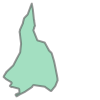

In [580]:
ph_shape

In [588]:
# Pre-check: filter storms that *start* outside and later intersect PCW
valid_sids = []
for sid, group in gdf_tracks.groupby("SID"):
    group = group.sort_values("ISO_TIME")
    starts_outside = not ph_prepared.contains(group.iloc[0].geometry)
    ever_inside = group.geometry.apply(ph_prepared.contains).any()
    if starts_outside and ever_inside:
        valid_sids.append(sid)

# print(f"✅ {len(valid_sids)} TCs enter from outside into PCW.")
# Find storms that start outside but enter PCW
origin_inside = gdf_tracks.groupby("SID").first()["geometry"].apply(ph_shape.contains)
sids_origin_outside = origin_inside[~origin_inside].index

# Final valid sids are those that both entered and originated outside
final_valid_sids = list(set(valid_sids).intersection(set(sids_origin_outside)))
len(final_valid_sids)

391

In [582]:
# from shapely.prepared import prep
# import geopandas as gpd
# import pandas as pd

# # Prep the PCW geometry (ph_buffered should already be a polygon)
# ph_prepared = prep(ph_shape)

# # Create list to store intersecting points
# landfall_point_records = []

# # Loop through each storm
# for sid, group in tqdm(gdf_tracks.groupby("SID")):
#     for idx, row in group.iterrows():
#         point_geom = row.geometry
#         if point_geom is not None and ph_prepared.contains(point_geom):
#             record = row.copy()
#             landfall_point_records.append(record)

# # Create new GeoDataFrame
# if landfall_point_records:
#     gdf_landfall_points = gpd.GeoDataFrame(landfall_point_records, geometry='geometry', crs=gdf_tracks.crs)
#     print(f"✅ Found {len(gdf_landfall_points)} TC points intersecting PCW.")
# else:
#     gdf_landfall_points = gpd.GeoDataFrame(columns=gdf_tracks.columns, geometry='geometry', crs=gdf_tracks.crs)
#     print("⚠️ No intersection points found.")

# # Optional: Quick sanity check
# # print(gdf_landfall_points[['SID', 'ISO_TIME', 'LAT', 'LON']].head())
# gdf_first_landfall_points = gdf_landfall_points.sort_values('ISO_TIME').groupby('SID').first().reset_index()

from shapely.geometry import LineString
from shapely.prepared import prep
from shapely.ops import split
import geopandas as gpd
import pandas as pd
# from tqdm import tqdm

# Prep the PCW shape
ph_prepared = prep(ph_shape)

# Store landfall points
landfall_records = []

# Filter to only TCs that intersected PCW (e.g., passed your new filtering)
gdf_tracks_lf = gdf_tracks[gdf_tracks["SID"].isin(valid_sids)]

# Loop through storms
for sid, group in tqdm(gdf_tracks_lf.groupby("SID")):
    group = group.sort_values("ISO_TIME").reset_index(drop=True)
    points = list(group["geometry"])
    
    for i in range(len(points) - 1):
        p1, p2 = points[i], points[i + 1]
        segment = LineString([p1, p2])

        # Only proceed if segment intersects PCW
        if segment.intersects(ph_shape):
            intersection = segment.intersection(ph_shape)

            # If it's a Point or MultiPoint, store it
            if intersection.is_empty:
                continue
            elif intersection.geom_type == "Point":
                lf_point = intersection
            elif intersection.geom_type == "MultiPoint":
                lf_point = list(intersection.geoms)[0]  # take the first one
            elif intersection.geom_type == "LineString":
                lf_point = intersection.interpolate(0.0)  # start of line
            else:
                continue  # skip unrecognized geometry types

            # Add metadata
            row = group.iloc[i + 1].copy()  # Take next point's time/metadata
            row["geometry"] = lf_point
            landfall_records.append(row)
            break  # only keep FIRST landfall per storm

# Create GeoDataFrame
if landfall_records:
    gdf_first_landfall_points = gpd.GeoDataFrame(landfall_records, geometry="geometry", crs=gdf_tracks.crs)
    print(f"✅ Found {len(gdf_first_landfall_points)} first landfall points.")
else:
    gdf_first_landfall_points = gpd.GeoDataFrame(columns=gdf_tracks.columns, geometry="geometry", crs=gdf_tracks.crs)
    print("⚠️ No first landfall points found.")


100%|███████████████████████████████████████████████████| 391/391 [00:02<00:00, 153.15it/s]

✅ Found 391 first landfall points.


<Axes: >

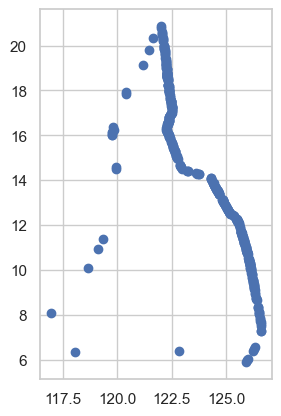

In [583]:
gdf_first_landfall_points.plot()

In [598]:
# Extract the northernmost point (highest latitude) and get its longitude
northmost_point = max(ph_shape.exterior.coords, key=lambda x: x[1])  # x = (lon, lat)
lon_cutoff = northmost_point[0]  # This will be used as a westward filter
print(f"Northernmost latitude at longitude: {lon_cutoff:.2f}")
west_sids = gdf_first_landfall_points[gdf_first_landfall_points.LON<121.95].SID.unique()

Northernmost latitude at longitude: 121.95


In [599]:
import os
import matplotlib.pyplot as plt

# Make sure output directory exists
output_dir = "plot"
os.makedirs(output_dir, exist_ok=True)

# Loop through each SID
for sid in west_sids:
    # Filter track
    df_sid = gdf_tracks[gdf_tracks["SID"] == sid]

    # Set up plot
    fig, ax = plt.subplots(figsize=(6, 8))

    # Plot map background
    phil_waters.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.8)
    phil_coast.plot(ax=ax, color='grey', edgecolor='black', linewidth=0.8)

    # Plot TC track
    df_sid.plot(ax=ax, color='red', markersize=8, label=f"Track: {sid}")

    # Optional: annotate start and end
    if not df_sid.empty:
        ax.annotate("Start", xy=(df_sid.iloc[0].geometry.x, df_sid.iloc[0].geometry.y),
                    xytext=(3, 3), textcoords="offset points", fontsize=8)
        ax.annotate("End", xy=(df_sid.iloc[-1].geometry.x, df_sid.iloc[-1].geometry.y),
                    xytext=(3, 3), textcoords="offset points", fontsize=8)

    # Styling
    ax.set_title(f"TC Track: {sid}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(115, 130)
    ax.set_ylim(5, 22)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Save figure
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{sid}.png", dpi=200)
    plt.close()

print(f"✅ Finished plotting {len(west_sids)} tracks to {output_dir}/")


✅ Finished plotting 61 tracks to plot/


In [520]:
# Step 1: Get SIDs that intersect PH and PAR
# sids_ph = df_intersects[df_intersects["intersects_ph"]]["SID"]
sids_ph = valid_sids
sids_par = df_intersects[df_intersects["intersects_par"]]["SID"]

# Step 2: Count number of 3-hourly points within each region

# For PH
ph_lifetime = (
    gdf_tracks[gdf_tracks["SID"].isin(sids_ph)]
    .groupby("SID")
    .size()
    .reset_index(name="n_points")
)
ph_lifetime["hours_total_ph"] = ph_lifetime["n_points"] * 3

# For PAR
par_lifetime = (
    gdf_tracks[gdf_tracks["SID"].isin(sids_par)]
    .groupby("SID")
    .size()
    .reset_index(name="n_points")
)
par_lifetime["hours_total_par"] = par_lifetime["n_points"] * 3

# Step 3: Compute average
avg_total_ph_hours = ph_lifetime["hours_total_ph"].mean()
avg_total_par_hours = par_lifetime["hours_total_par"].mean()

print(f"Average lifetime of TCs intersecting Ph (for {len(ph_lifetime)} storms): {avg_total_ph_hours:.1f} hours")
print(f"Average lifetime of TCs intersecting PAR (for {len(par_lifetime)} storms): {avg_total_par_hours:.1f} hours")


Average lifetime of TCs intersecting Ph (for 421 storms): 223.7 hours
Average lifetime of TCs intersecting PAR (for 957 storms): 225.7 hours


In [522]:
# Filter points inside PH buffer
ph_inside = gdf_tracks[
    (gdf_tracks["SID"].isin(sids_ph)) & 
    (gdf_tracks.geometry.within(ph_buffered))
]

# Count points per SID
ph_lf_lifetime = (
    ph_inside.groupby("SID")
    .size()
    .reset_index(name="n_points")
)
ph_lf_lifetime["hours_inside_ph"] = ph_lf_lifetime["n_points"] * 3

# Compute average lifetime inside PH
avg_ph_hours = ph_lf_lifetime["hours_inside_ph"].mean()
print(f"Average TC lifetime *inside PH buffer*: {avg_ph_hours:.1f} hours (based on {len(ph_lf_lifetime)} storms)")


Average TC lifetime *inside PH buffer*: 28.2 hours (based on 421 storms)


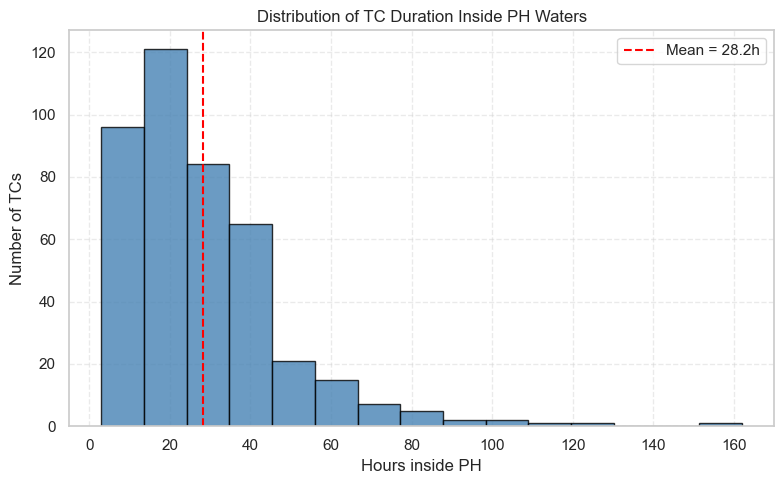

In [523]:
plt.figure(figsize=(8, 5))
plt.hist(ph_lf_lifetime["hours_inside_ph"], bins=15, color='steelblue', edgecolor='black', alpha=0.8)

plt.title("Distribution of TC Duration Inside PH Waters")
plt.xlabel("Hours inside PH")
plt.ylabel("Number of TCs")
plt.grid(True, linestyle='--', alpha=0.4)

# Optional: mark mean
mean_duration = ph_lf_lifetime["hours_inside_ph"].mean()
plt.axvline(mean_duration, color='red', linestyle='--', label=f"Mean = {mean_duration:.1f}h")
plt.legend()

plt.tight_layout()
plt.show()

In [524]:
# Filter points inside PAR
par_inside = gdf_tracks[
    (gdf_tracks["SID"].isin(sids_par)) & 
    (gdf_tracks.geometry.within(par_poly))
]

# Count points per SID
par_enter_lifetime = (
    par_inside.groupby("SID")
    .size()
    .reset_index(name="n_points")
)
par_enter_lifetime["hours_inside_par"] = par_enter_lifetime["n_points"] * 3

# Compute average lifetime inside PAR
avg_par_hours = par_enter_lifetime["hours_inside_par"].mean()
print(f"Average TC lifetime *inside PAR*: {avg_par_hours:.1f} hours (based on {len(par_enter_lifetime)} storms)")


Average TC lifetime *inside PAR*: 85.4 hours (based on 946 storms)


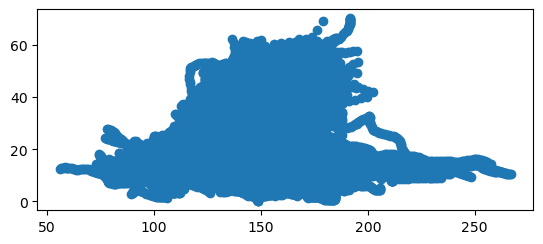

In [11]:
gdf_tracks.plot()
plt.show()

In [525]:
landfall_sids = valid_sids
len(landfall_sids)

421

In [13]:
df_intersects

,SID,intersects_ph,intersects_par
0,1978361N02180,False,True
1,1979077N07150,False,True
2,1979098N02144,True,True
3,1979126N04148,True,True
4,1979137N19116,False,True
...,...,...,...
1501,2024308N10138,True,True
1502,2024314N14132,True,True
1503,2024314N14160,True,True
1504,2024316N12139,True,True


In [526]:
# Initialize the new columns
gdf_tracks['intersects_ph'] = False
gdf_tracks['intersects_par'] = False

# Filter SIDs from df_intersects where intersections occurred
ph_sids = valid_sids
par_sids = df_intersects[df_intersects['intersects_par'] == True]['SID']

# Update gdf_tracks based on SIDs
gdf_tracks.loc[gdf_tracks['SID'].isin(ph_sids), 'intersects_ph'] = True
gdf_tracks.loc[gdf_tracks['SID'].isin(par_sids), 'intersects_par'] = True
gdf_lf = gdf_tracks[gdf_tracks['intersects_ph']].copy().reset_index(drop=True)
gdf_par = gdf_tracks[gdf_tracks['intersects_par']].copy().reset_index(drop=True)

In [35]:
import numpy as np

In [607]:
def label_tc_by_segment_intersection(df_sid, ph_prepared, time_col='ISO_TIME'):
    df_sid = df_sid.sort_values(time_col).reset_index(drop=True)
    df_sid['phase'] = 'outside'
    df_sid['t_hours'] = np.nan

    entry_idx = None
    exit_idx = None

    # Generate segment lines and check for intersection
    for i in range(len(df_sid) - 1):
        p1 = df_sid.at[i, 'geometry']
        p2 = df_sid.at[i + 1, 'geometry']
        segment = LineString([p1, p2])

        if ph_prepared.intersects(segment):
            if entry_idx is None:
                entry_idx = i  # First intersecting segment
            exit_idx = i + 1  # Keep updating until last intersecting segment

    if entry_idx is None or exit_idx is None:
        return df_sid  # No intersection; skip labeling

    # Time reference point = first entry
    t_entry = df_sid.at[entry_idx, time_col]

    # Label phases and compute t_hours
    for i in range(len(df_sid)):
        current_time = df_sid.at[i, time_col]
        t_diff = (current_time - t_entry).total_seconds() / 3600

        if i < entry_idx:
            df_sid.at[i, 'phase'] = 'approach'
            df_sid.at[i, 't_hours'] = t_diff
        elif entry_idx <= i <= exit_idx:
            df_sid.at[i, 'phase'] = 'within'
            df_sid.at[i, 't_hours'] = t_diff
        elif i > exit_idx:
            df_sid.at[i, 'phase'] = 'departure'
            df_sid.at[i, 't_hours'] = t_diff

    return df_sid

def label_and_interpolate_tc(
    gdf_lf, 
    ph_mask_col='intersects_ph', 
    wind_col='WMO_WIND', 
    time_col='ISO_TIME', 
    dir_col='STORM_DIR',
    spd_col='STORM_SPEED',
    max_hours=48,
    filter_westward=True,
    verbose=False
):
    """
    Labels TC points as 'approach', 'within', or 'departure' and interpolates WMO_WIND.
    Optionally filters westward-moving TCs and handles string direction values.
    """
    processed = []

    # for sid in gdf_lf['SID'].unique():
    for sid in tqdm(gdf_lf['SID'].unique(), desc="Processing TCs"):

        df_sid = gdf_lf[gdf_lf['SID'] == sid].copy()
        df_sid = df_sid.sort_values(time_col).reset_index(drop=True)
        df_sid[time_col] = pd.to_datetime(df_sid[time_col]) 

        # Force numeric STORM_DIR (errors='coerce' sets invalid to NaN)
        df_sid[dir_col] = pd.to_numeric(df_sid[dir_col], errors='coerce')
        df_sid[spd_col] = pd.to_numeric(df_sid[spd_col], errors='coerce')

        # Compute STORM_ACCEL (change in speed from previous time step)
        speeds = df_sid[spd_col].to_numpy(dtype='float')  
        accel = speeds - np.roll(speeds, 1)
        accel[0] = np.nan  # first difference is undefined
        df_sid['STORM_ACCEL'] = accel

        
        # Optional: filter out non-westward TCs
        if filter_westward:
            valid_dirs = df_sid[dir_col].dropna()
            if valid_dirs.empty or not ((valid_dirs > 180) & (valid_dirs < 360)).any():
                if verbose:
                    print(f"Skipping SID {sid}: no valid westward direction")
                continue

        # After direction filtering, add this:
        start_point = df_sid.iloc[0].geometry
        if ph_prepared.contains(start_point):
            if verbose:
                print(f"Skipping SID {sid}: starts inside PCW")
            continue

        
        # Skip if no intersecting points
        if not df_sid[ph_mask_col].any():
            if verbose:
                print(f"Skipping SID {sid}: no intersection")
            continue

        df_sid = label_tc_by_segment_intersection(df_sid, ph_prepared, time_col='ISO_TIME')

        
        # Interpolation
        in_window = df_sid['phase'].isin(['approach', 'within', 'departure'])
        df_sid['WMO_WIND_interp'] = np.nan

        # if df_sid.loc[in_window, wind_col].notna().sum() >= 2:
        #     df_sid.loc[in_window, 'WMO_WIND_interp'] = df_sid.loc[in_window, wind_col].interpolate(method='linear')

        # Clean and convert wind to float
        df_sid[wind_col] = pd.to_numeric(df_sid[wind_col], errors='coerce')
        
        # # Interpolate only if enough valid values
        # if df_sid.loc[in_window, wind_col].notna().sum() >= 2:
        #     df_sid.loc[in_window, 'WMO_WIND_interp'] = (
        #         df_sid.loc[in_window, wind_col]
        #         .interpolate(method='linear')
        #         .astype(float)  # Ensure it's float for assignment
        #     )

        # Interpolate only if enough valid values
        wind_series = df_sid.loc[in_window, wind_col]
        
        if wind_series.notna().sum() >= 2:
            interpolated = wind_series.interpolate(method='linear')
        
            # Mask out extrapolated values
            first_valid = wind_series.first_valid_index()
            last_valid = wind_series.last_valid_index()
        
            # interpolated.loc[:first_valid] = np.nan
            # interpolated.loc[last_valid+1:] = np.nan
        
            first_pos = wind_series.index.get_loc(first_valid)
            last_pos = wind_series.index.get_loc(last_valid)
            
            # Mask *before* first and *after* last (but not the valid points themselves)
            interpolated.iloc[:first_pos] = np.nan
            interpolated.iloc[last_pos+1:] = np.nan

            
            df_sid.loc[in_window, 'WMO_WIND_interp'] = interpolated.astype(float)

        
        processed.append(df_sid)

    df_out = pd.concat(processed, ignore_index=True)
    return df_out
df_ph_labeled = label_and_interpolate_tc(gdf_lf, filter_westward=True, verbose=True)


Processing TCs:   0%|          | 0/421 [00:00<?, ?it/s]

Skipping SID 1994197N14115: no valid westward direction
Skipping SID 1996137N13111: no valid westward direction
Skipping SID 1996356N08110: no valid westward direction
Skipping SID 1997143N17111: no valid westward direction
Skipping SID 2000138N16119: no valid westward direction
Skipping SID 2000141N18116: no valid westward direction
Skipping SID 2014160N21120: no valid westward direction
Skipping SID 2017291N09116: no valid westward direction


In [608]:
df_ph_labeled.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,USA_SEARAD_NW,STORM_SPEED,STORM_DIR,geometry,intersects_ph,intersects_par,STORM_ACCEL,phase,t_hours,WMO_WIND_interp
0,1979098N02144,1979,23,WP,MM,CECIL,1979-04-08 00:00:00,TS,2.4,143.6,...,,7,340,POINT (143.60000 2.40000),True,True,NaN,approach,-174.0,NaN
1,1979098N02144,1979,23,WP,MM,CECIL,1979-04-08 03:00:00,TS,2.7,143.4,...,,7,340,POINT (143.40000 2.70000),True,True,0.0,approach,-171.0,NaN
2,1979098N02144,1979,23,WP,MM,CECIL,1979-04-08 06:00:00,TS,3.0,143.3,...,,6,345,POINT (143.30000 3.00000),True,True,-1.0,approach,-168.0,NaN
3,1979098N02144,1979,23,WP,MM,CECIL,1979-04-08 09:00:00,TS,3.3,143.3,...,,6,345,POINT (143.30000 3.30000),True,True,0.0,approach,-165.0,NaN
4,1979098N02144,1979,23,WP,MM,CECIL,1979-04-08 12:00:00,TS,3.6,143.2,...,,4,340,POINT (143.20000 3.60000),True,True,-2.0,approach,-162.0,NaN


In [427]:
df_par_labeled = label_and_interpolate_tc(gdf_par, filter_westward=True, verbose=True, ph_mask_col='intersects_par')


Processing TCs:   0%|          | 0/957 [00:00<?, ?it/s]

Skipping SID 1981214N16133: no valid westward direction
Skipping SID 1983352N08129: no valid westward direction
Skipping SID 1985013N11131: no valid westward direction
Skipping SID 1985168N22122: no valid westward direction
Skipping SID 1989235N26122: no valid westward direction
Skipping SID 1994197N14115: no valid westward direction
Skipping SID 1996137N13111: no valid westward direction
Skipping SID 1996356N08110: no valid westward direction
Skipping SID 1997143N17111: no valid westward direction
Skipping SID 1998243N23122: no valid westward direction
Skipping SID 2000138N16119: no valid westward direction
Skipping SID 2000141N18116: no valid westward direction
Skipping SID 2002146N17113: no valid westward direction
Skipping SID 2013243N26122: no valid westward direction
Skipping SID 2014160N21120: no valid westward direction
Skipping SID 2016250N25125: no valid westward direction
Skipping SID 2017291N09116: no valid westward direction
Skipping SID 2018164N21120: no valid westward di

In [444]:
df_ph_labeled.STORM_SPEED.describe()

count    32742.000000
mean        10.434060
std          5.398268
min          0.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         62.000000
Name: STORM_SPEED, dtype: float64

In [529]:

# Create a copy just in case
df_plot = df_ph_labeled.copy()

# Round t_hours to nearest 3-hour step
df_plot['t_rounded'] = df_plot['t_hours'].round()

# Filter to relevant range (±48 hours)
df_plot = df_plot[df_plot['t_rounded'].between(-48, 48)]


In [530]:
df_plot.t_hours.max()

48.0

In [531]:
def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

grouped = df_plot.groupby('t_rounded')['WMO_WIND_interp']
stats_df = grouped.agg(
    mean='mean',
    median='median',
    count='count',
    p25=lambda x: safe_percentile(x, 25),
    p75=lambda x: safe_percentile(x, 75)
).reset_index()


In [360]:
# fig, ax = plt.subplots(figsize=(10, 6))

# # Faint individual TC lines
# for sid, group in df_plot.groupby('SID'):
#     ax.plot(group['t_rounded'], group['WMO_WIND_interp'], 
#             color='lightgray', alpha=0.25, linewidth=0.8)

# # IQR band
# ax.fill_between(stats_df['t_rounded'], stats_df['p25'], stats_df['p75'],
#                 color='lightblue', alpha=0.4, label='IQR (25–75%)')

# # Mean line
# ax.plot(stats_df['t_rounded'], stats_df['mean'], color='blue', linewidth=2, label='Mean')

# # Vertical line at t=0
# ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# # Add count labels every 3-hour point
# for i, row in stats_df.iterrows():
#     ax.annotate(f"n={int(row['count'])}", 
#                 (row['t_rounded'], row['mean']), 
#                 textcoords="offset points", xytext=(0, 5),
#                 ha='center', fontsize=7, alpha=0.6)

# # Reverse X-axis: Approach → right; Departure → left
# ax.invert_xaxis()

# # Labels and grid
# ax.set_title('TC Intensity Relative to PH Entry (t=0)')
# ax.set_xlabel('Hours relative to PH entry (t=0)')
# ax.set_ylabel('Interpolated Wind Speed (knots)')
# ax.legend()
# ax.grid(True, linestyle='--', alpha=0.4)

# plt.tight_layout()
# plt.show()


In [532]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Split the data into phases
df_approach = df_ph_labeled[df_ph_labeled['phase'] == 'approach'].copy()
df_within = df_ph_labeled[df_ph_labeled['phase'] == 'within'].copy()
df_departure = df_ph_labeled[df_ph_labeled['phase'] == 'departure'].copy()

# Step 2: Round t_hours to nearest 3h step
for df in [df_approach, df_within, df_departure]:
    df['t_step'] = df['t_hours'].round()

# Approach: keep only t_step from -48 to 0
df_approach = df_approach[df_approach['t_step'].between(-48, 0)]

# Departure: keep only t_step from 0 to +48
df_departure = df_departure[df_departure['t_step'].between(0, 48)]

# Within already truncated
df_within = df_within[df_within['t_step'] <= 48]


def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan


# Step 4: Stats computation function
def compute_stats(df):
    grouped = df.groupby('t_step')['WMO_WIND_interp']
    return grouped.agg(
        mean='mean',
        p25=lambda x: safe_percentile(x, 25),
        p75=lambda x: safe_percentile(x, 75)
    ).reset_index()


# Step 5: Compute stats for each phase
stats_approach = compute_stats(df_approach)
stats_within = compute_stats(df_within)
stats_departure = compute_stats(df_departure)




In [533]:
def plot_phase(ax, df, stats, title, x_reverse=False, x_flip_labels=False):
    for sid, group in df.groupby('SID'):
        ax.plot(group['t_step'], group['WMO_WIND_interp'], color='lightgray', alpha=0.25)

    ax.fill_between(stats['t_step'], stats['p25'], stats['p75'], color='lightblue', alpha=0.4, label='IQR (25–75%)')
    ax.plot(stats['t_step'], stats['mean'], color='blue', linewidth=2, label='Mean')

    if x_reverse:
        ax.set_xlim(ax.get_xlim()[::-1])  # Flip x-axis direction (but keep axis labels intact)

    if x_flip_labels:
        from matplotlib.ticker import FixedLocator
        
        ticks = ax.get_xticks()
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        ax.set_xticklabels([int(-1 * t) for t in ticks])


    ax.set_title(title)
    ax.set_xlabel('Relative time (hours)')
    ax.grid(True, linestyle='--', alpha=0.3)


In [399]:
# fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# # LEFT: Departure (positive → 0)
# plot_phase(axs[0], df_departure, stats_departure, "Departure from PH",
#            x_reverse=True, x_flip_labels=False)

# # CENTER: Within (0 → +48)
# plot_phase(axs[1], df_within, stats_within, "Within PH Waters (≤ 48h)",
#            x_reverse=False, x_flip_labels=True)

# # RIGHT: Approach (0 → -48 shown as -48 to 0 left to right)
# plot_phase(axs[2], df_approach, stats_approach, "Approach to PH",
#            x_reverse=True, x_flip_labels=True)


In [543]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Step 1: Round t_hours
# df_plot = df_ph_labeled.copy()
# df_plot['t_step'] = df_plot['t_hours'].round()

# # Optional: Limit to ±72h
# df_plot = df_plot[df_plot['t_step'].between(-72, 72)]

# # Step 2: Safe stats
# def safe_percentile(x, q):
#     x_clean = x.dropna()
#     return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

# def compute_stats(df):
#     grouped = df.groupby('t_step')['WMO_WIND_interp']
#     return grouped.agg(
#         median='median',
#         count='count',
#         p25=lambda x: safe_percentile(x, 25),
#         p75=lambda x: safe_percentile(x, 75)
#     ).reset_index()

# stats = compute_stats(df_plot)

# stats = stats[stats['count'] >= 5]


In [544]:
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Main intensity plot
# for sid, group in df_plot.groupby('SID'):
#     ax1.plot(group['t_step'], group['WMO_WIND_interp'], color='lightgray', alpha=0.25)

# ax1.fill_between(stats['t_step'], stats['p25'], stats['p75'], color='lightblue', alpha=0.4, label='IQR')
# ax1.plot(stats['t_step'], stats['median'], color='blue', linewidth=2, label='Median')
# ax1.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax1.set_xlabel("Hours relative to PH entry (t = 0)")
# ax1.set_ylabel("Interpolated Wind Speed (knots)")
# ax1.grid(True, linestyle='--', alpha=0.3)
# ax1.legend(loc='upper left')

# # Secondary axis for storm count
# ax2 = ax1.twinx()
# ax2.plot(stats['t_step'], stats['count'], color='orange', alpha=0.6, linestyle='--', label='Storm count')
# ax2.set_ylabel("Number of storms contributing")
# ax2.legend(loc='upper right')
# ax2.invert_xaxis()
# plt.title("TC Intensity Relative to PH Entry (Median + IQR)\nwith Storm Count per Time Step")
# plt.tight_layout()
# plt.show()


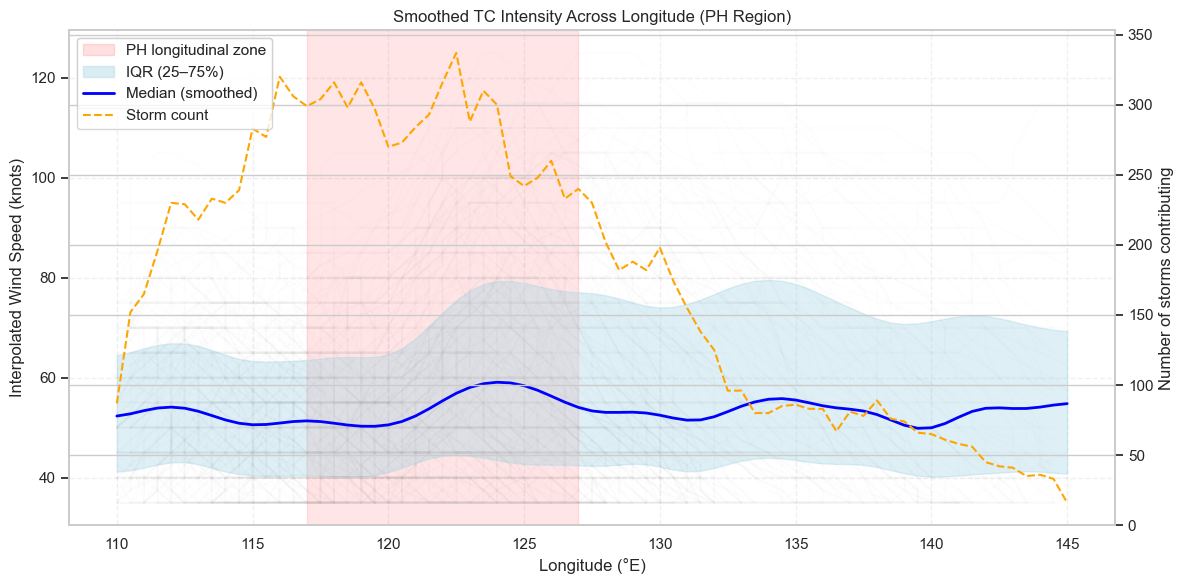

In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# 🌀 Use your actual TC DataFrame here
df_plot = df_ph_labeled.copy()
df_plot = df_plot[df_plot['WMO_WIND_interp'].notna()]
df_plot['lon'] = df_plot.geometry.x  # adjust if needed

# 📌 Limit to the West Pacific region
df_plot = df_plot[(df_plot['lon'] >= 110) & (df_plot['lon'] <= 145)]

# 📦 Bin longitudes into 0.5°
bin_width = 0.5
df_plot['lon_bin'] = (df_plot['lon'] / bin_width).round() * bin_width

# 📊 Compute statistics per bin
def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

stats = df_plot.groupby('lon_bin')['WMO_WIND_interp'].agg(
    median='median',
    p25=lambda x: safe_percentile(x, 25),
    p75=lambda x: safe_percentile(x, 75),
    count='count'
).reset_index()

# 🔍 Filter bins with low counts
stats = stats[stats['count'] >= 5]

# 🌊 Smooth the data
stats['median_smooth'] = gaussian_filter1d(stats['median'], sigma=2)
stats['p25_smooth'] = gaussian_filter1d(stats['p25'], sigma=2)
stats['p75_smooth'] = gaussian_filter1d(stats['p75'], sigma=2)

# 🎨 Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# 🔹 Plot individual TC tracks (gray lines)
for sid, group in df_plot.groupby('SID'):
    ax.plot(group['lon_bin'], group['WMO_WIND_interp'], color='gray', alpha=0.01)

# 📍 Highlight PH zone
ph_lon_min, ph_lon_max = 117, 127
ax.axvspan(ph_lon_min, ph_lon_max, color='red', alpha=0.1, label='PH longitudinal zone')

# 📈 Smoothed stats
ax.fill_between(stats['lon_bin'], stats['p25_smooth'], stats['p75_smooth'],
                color='lightblue', alpha=0.4, label='IQR (25–75%)')
ax.plot(stats['lon_bin'], stats['median_smooth'], color='blue', linewidth=2, label='Median (smoothed)')

# 🧭 Labels and formatting
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Interpolated Wind Speed (knots)")
ax.set_title("Smoothed TC Intensity Across Longitude (PH Region)")
ax.grid(True, linestyle='--', alpha=0.3)

# 🟡 Plot storm count using secondary y-axis
ax2 = ax.twinx()
ax2.plot(stats['lon_bin'], stats['count'], color='orange', linestyle='--', label='Storm count')
ax2.set_ylabel("Number of storms contributing")
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

ax.legend()
plt.tight_layout()
plt.show()


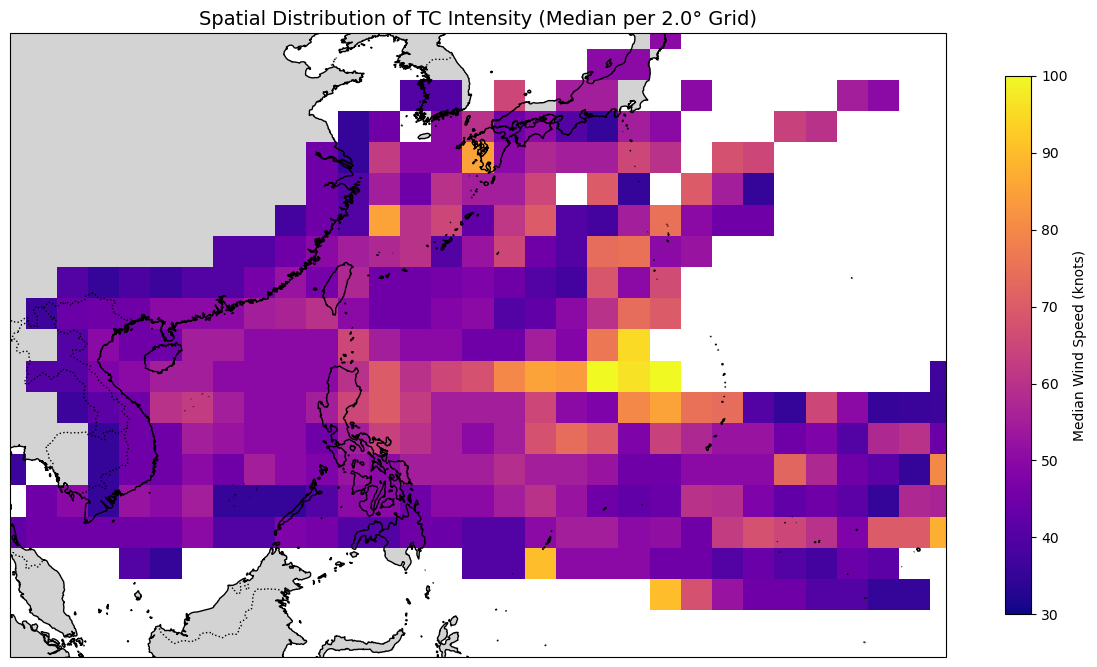

In [164]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 💡 Use your actual df_ph_labeled
df_map = df_ph_labeled.copy()
df_map = df_map[df_map['WMO_WIND_interp'].notna()]
df_map['lon'] = df_map.geometry.x
df_map['lat'] = df_map.geometry.y

# 🔧 Adjustable bin size
bin_size = 2
df_map['lon_bin'] = (df_map['lon'] / bin_size).round() * bin_size
df_map['lat_bin'] = (df_map['lat'] / bin_size).round() * bin_size

# 📊 Median wind speed per bin
grid_stats = df_map.groupby(['lat_bin', 'lon_bin'])['WMO_WIND_interp'].median().reset_index()
pivot = grid_stats.pivot(index='lat_bin', columns='lon_bin', values='WMO_WIND_interp')
lon_grid = pivot.columns.values
lat_grid = pivot.index.values
Z = pivot.values
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# 🗺️ Plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
mesh = ax.pcolormesh(lon_mesh, lat_mesh, Z, shading='auto', cmap='plasma', vmin=30, vmax=100)

# 🌐 Map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_extent([100, 160, 0, 40], crs=ccrs.PlateCarree())

# 🎨 Colorbar and labels
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', shrink=0.7, label='Median Wind Speed (knots)')
ax.set_title('Spatial Distribution of TC Intensity (Median per {:.1f}° Grid)'.format(bin_size), fontsize=14)

plt.tight_layout()
plt.show()


In [610]:
# import numpy as np
# import pandas as pd
# from tqdm.auto import tqdm

# # Make sure your DataFrame has the following:
# # - 'SID' (storm ID)
# # - 't_hours' (time relative to PH landfall, in hours)
# # - 'WMO_WIND_interp' (interpolated wind speed)
# # - sorted by ['SID', 't_hours']

# # Sort first to ensure order
# df_ph_labeled = df_ph_labeled.sort_values(['SID', 't_hours']).copy()

# # Initialize the new column
# df_ph_labeled['max_24h_intensification'] = np.nan

# # Loop through each storm
# for sid, group in tqdm(df_ph_labeled.groupby('SID'), desc="Processing storms"):
#     group = group.sort_values('t_hours').copy()
#     intensification_list = []

#     for i, current in group.iterrows():
#         current_time = current['t_hours']
#         current_wind = current['WMO_WIND_interp']

#         if np.isnan(current_wind):
#             intensification_list.append(np.nan)
#             continue

#         # Look back within the last 24 hours
#         past_window = group[(group['t_hours'] < current_time) & 
#                             (group['t_hours'] >= current_time - 24)]

#         max_increase = np.nan
#         for _, past in past_window.iterrows():
#             past_wind = past['WMO_WIND_interp']
#             if not np.isnan(past_wind):
#                 delta = current_wind - past_wind
#                 if np.isnan(max_increase) or delta > max_increase:
#                     max_increase = delta

#         intensification_list.append(max_increase)

#     # Assign back to the original df using group index
#     df_ph_labeled.loc[group.index, 'max_24h_intensification'] = intensification_list


import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Make sure your DataFrame has the following:
# - 'SID' (storm ID)
# - 't_hours' (time relative to PH landfall, in hours)
# - 'WMO_WIND_interp' (interpolated wind speed)
# - sorted by ['SID', 't_hours']

# Sort first to ensure order
df_ph_labeled = df_ph_labeled.sort_values(['SID', 't_hours']).copy()

# Initialize the new columns
df_ph_labeled['max_24h_intensification'] = np.nan
df_ph_labeled['delta_3hr'] = np.nan
df_ph_labeled['max_24h_acceleration'] = np.nan

# Loop through each storm
for sid, group in tqdm(df_ph_labeled.groupby('SID'), desc="Processing storms"):
    group = group.sort_values('t_hours').copy()
    intensification_list = []
    delta_3hr_list = []
    acceleration_list = []

    for i, current in group.iterrows():
        current_time = current['t_hours']
        current_wind = current['WMO_WIND_interp']
        # current_speed = current['STORM_SPEED']

        if np.isnan(current_wind):
            intensification_list.append(np.nan)
            delta_3hr_list.append(np.nan)
            # acceleration_list.append(np.nan) 
            continue

        # ================================
        # 1. Calculate the 24-hour max intensification
        past_window = group[(group['t_hours'] < current_time) & 
                            (group['t_hours'] >= current_time - 24)]
        
        max_increase = np.nan
        for _, past in past_window.iterrows():
            past_wind = past['WMO_WIND_interp']
            if not np.isnan(past_wind):
                delta = current_wind - past_wind
                if np.isnan(max_increase) or delta > max_increase:
                    max_increase = delta
        intensification_list.append(max_increase)
        
        # ================================
        # 2. Calculate the change in intensity (delta_3hr)
        past_window_3hr = group[(group['t_hours'] < current_time) & 
                                (group['t_hours'] >= current_time - 3)]

        if not past_window_3hr.empty:
            past_wind_3hr = past_window_3hr.iloc[-1]['WMO_WIND_interp']
            delta_3hr = current_wind - past_wind_3hr
        else:
            delta_3hr = np.nan

        delta_3hr_list.append(delta_3hr)

    for i, current in group.iterrows():
        # current_time = current['t_hours']
        # current_wind = current['WMO_WIND_interp']
        current_speed = current['STORM_SPEED']

        if np.isnan(current_speed):
            # intensification_list.append(np.nan)
            # delta_3hr_list.append(np.nan)
            acceleration_list.append(np.nan) 
            continue
        # ================================
        # 3. Max 24h Speed Change (NEW)
        speed_window = group[(group['t_hours'] < current_time) & 
                             (group['t_hours'] >= current_time - 24)]
        # speed_vals = speed_window['STORM_SPEED'].dropna().values
        max_increase_spd = np.nan
        for _, past in speed_window.iterrows():
            past_speed = past['STORM_SPEED']
            if not np.isnan(past_speed):
                delta = current_speed - past_speed
                if np.isnan(max_increase_spd) or delta > max_increase_spd:
                    max_increase_spd = delta
        acceleration_list.append(max_increase_spd)

        # if len(speed_vals) > 0:
        #     speed_change = np.max(speed_vals) - np.min(speed_vals)
        # else:
        #     speed_change = np.nan
        # acceleration_list.append(speed_change)

    # Assign the results back to the original df using group index
    df_ph_labeled.loc[group.index, 'max_24h_intensification'] = intensification_list
    df_ph_labeled.loc[group.index, 'delta_3hr'] = delta_3hr_list
    # print(sid, len(group.index), len(acceleration_list))

    df_ph_labeled.loc[group.index, 'max_24h_acceleration'] = acceleration_list  # NEW
# Output the updated DataFrame with both 'max_24h_intensification' and 'delta_3hr'
# df_ph_labeled.head()


Processing storms:   0%|          | 0/413 [00:00<?, ?it/s]

In [606]:
df_ph_labeled.head()


,t_hours,STORM_SPEED,max_24h_acceleration
0,0,8,0
1,0,11,-1
2,0,14,2
3,0,11,3
4,0,14,-4


In [611]:
# # import numpy as np
# # import pandas as pd

# # --- Helper function for safe percentile ---
# def safe_percentile(x, q):
#     x_clean = x.dropna()
#     return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

# # Make sure df_ph_labeled has 't_hours', 't_step', 'WMO_WIND_interp', 'max_24h_intensification', and 'delta_3hr'
# df_plot = df_ph_labeled.copy()
# df_plot = df_plot[df_plot['t_hours'].notna()]
# df_plot['t_step'] = df_plot['t_hours'].round()

# # Optional: Limit to ±72h
# df_plot = df_plot[df_plot['t_step'].between(-72, 72)]

# # Group by time step
# grouped = df_plot.groupby('t_step')

# # Group and compute stats for all TCs
# stats = grouped.agg(
#     median=('WMO_WIND_interp', 'median'),
#     p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
#     p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
#     count=('WMO_WIND_interp', 'count'),
#     median_max_intens=('max_24h_intensification', 'median'),
#     p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
#     p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75)),
#     median_delta_3hr=('delta_3hr', 'median'),
#     p25_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 25)),
#     p75_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 75))
# ).reset_index()

# # Optional: Keep only bins with enough storms
# stats = stats[stats['count'] >= 5]

# # --- Tagging RI TCs based on max_24h_intensification >= 30 within ±72h ---
# ri_criteria = (
#     (df_ph_labeled['t_hours'] >= -72) &
#     (df_ph_labeled['t_hours'] <= 72) &
#     (df_ph_labeled['max_24h_intensification'] >= 30)
# )
# ri_sids = df_ph_labeled.loc[ri_criteria, 'SID'].unique()

# # Create new column for tagging
# df_ph_labeled['is_RI'] = df_ph_labeled['SID'].isin(ri_sids)

# # --- Subset for RI storms only ---
# df_ri = df_ph_labeled[df_ph_labeled['is_RI']].copy()
# df_ri = df_ri[df_ri['t_hours'].notna()]
# df_ri['t_step'] = df_ri['t_hours'].round()

# # Optional: Limit to ±72h
# df_ri = df_ri[df_ri['t_step'].between(-72, 72)]

# # Group by time step
# grouped_ri = df_ri.groupby('t_step')

# # Group and compute stats for RI TCs
# stats_ri = grouped_ri.agg(
#     median=('WMO_WIND_interp', 'median'),
#     p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
#     p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
#     count=('WMO_WIND_interp', 'count'),
#     median_max_intens=('max_24h_intensification', 'median'),
#     p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
#     p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75)),
#     median_delta_3hr=('delta_3hr', 'median'),
#     p25_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 25)),
#     p75_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 75))
# ).reset_index()

# # Optional: Keep only bins with enough storms
# stats_ri = stats_ri[stats_ri['count'] >= 5]

# # Now you can work with 'stats' and 'stats_ri' which includes delta_3hr values


import numpy as np
import pandas as pd

# --- Helper function for safe percentile ---
def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

# Prep main DF
df_plot = df_ph_labeled.copy()
df_plot = df_plot[df_plot['t_hours'].notna()]
df_plot['t_step'] = df_plot['t_hours'].round()
df_plot = df_plot[df_plot['t_step'].between(-72, 72)]

# --- Group and compute stats for all TCs ---
grouped = df_plot.groupby('t_step')

stats = grouped.agg(
    median=('WMO_WIND_interp', 'median'),
    p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
    p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
    count=('WMO_WIND_interp', 'count'),
    median_max_intens=('max_24h_intensification', 'median'),
    p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
    p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75)),
    median_delta_3hr=('delta_3hr', 'median'),
    p25_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 25)),
    p75_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 75)),
    median_speed=('STORM_SPEED', 'median'),
    p25_speed=('STORM_SPEED', lambda x: safe_percentile(x, 25)),
    p75_speed=('STORM_SPEED', lambda x: safe_percentile(x, 75)),
    median_accel=('STORM_ACCEL', 'median'),
    p25_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 25)),
    p75_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 75)),
    median_max_accel=('max_24h_acceleration', 'median'),
    p25_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 25)),
    p75_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 75)),
).reset_index()

stats = stats[stats['count'] >= 5]

# --- RI storm tagging ---
ri_criteria = (
    (df_ph_labeled['t_hours'] >= -72) &
    (df_ph_labeled['t_hours'] <= 72) &
    (df_ph_labeled['max_24h_intensification'] >= 30)
)
ri_sids = df_ph_labeled.loc[ri_criteria, 'SID'].unique()
df_ph_labeled['is_RI'] = df_ph_labeled['SID'].isin(ri_sids)

# Prep RI subset
df_ri = df_ph_labeled[df_ph_labeled['is_RI']].copy()
df_ri = df_ri[df_ri['t_hours'].notna()]
df_ri['t_step'] = df_ri['t_hours'].round()
df_ri = df_ri[df_ri['t_step'].between(-72, 72)]

# --- Group and compute stats for RI TCs ---
grouped_ri = df_ri.groupby('t_step')

stats_ri = grouped_ri.agg(
    median=('WMO_WIND_interp', 'median'),
    p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
    p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
    count=('WMO_WIND_interp', 'count'),
    median_max_intens=('max_24h_intensification', 'median'),
    p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
    p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75)),
    median_delta_3hr=('delta_3hr', 'median'),
    p25_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 25)),
    p75_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 75)),
    median_speed=('STORM_SPEED', 'median'),
    p25_speed=('STORM_SPEED', lambda x: safe_percentile(x, 25)),
    p75_speed=('STORM_SPEED', lambda x: safe_percentile(x, 75)),
    median_accel=('STORM_ACCEL', 'median'),
    p25_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 25)),
    p75_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 75)),
    median_max_accel=('max_24h_acceleration', 'median'),
    p25_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 25)),
    p75_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 75)),
).reset_index()

stats_ri = stats_ri[stats_ri['count'] >= 5]


In [539]:
# import matplotlib.pyplot as plt

# sample_sid = df_plot['SID'].unique()[0]
# sample = df_plot[df_plot['SID'] == sample_sid]

# plt.plot(sample['t_step'], sample['STORM_SPEED'], label='Speed')
# plt.plot(sample['t_step'], sample['STORM_ACCEL'], label='Accel', linestyle='--')
# plt.axhline(0, color='gray', linestyle=':')
# plt.legend()
# plt.title(f"STORM_SPEED and STORM_ACCEL – SID {sample_sid}")
# plt.xlabel("t_step")
# plt.ylabel("Knots / Accel")
# plt.grid(True)
# plt.show()


In [540]:
# import matplotlib.pyplot as plt

# fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# # ===== Top Plot: TC Intensity =====
# for sid, group in df_plot.groupby('SID'):
#     ax1.plot(group['t_step'], group['WMO_WIND_interp'], color='gray', alpha=0.01)

# ax1.fill_between(stats['t_step'], stats['p25'], stats['p75'], color='lightblue', alpha=0.4, label='IQR')
# ax1.plot(stats['t_step'], stats['median'], color='blue', linewidth=2, label='Median')
# ax1.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax1.set_ylabel("Interpolated Wind Speed (knots)")
# ax1.set_title("TC Intensity Relative to PH Entry")
# ax1.grid(True, linestyle='--', alpha=0.3)
# ax1.legend(loc='upper left')
# # ax1.invert_xaxis()
# # Storm count on twin axis (optional)
# ax2 = ax1.twinx()
# ax2.plot(stats['t_step'], stats['count'], color='orange', linestyle='--', alpha=0.6, label='Storm count')
# ax2.set_ylabel("Storm count")
# ax2.tick_params(axis='y', labelcolor='orange')
# ax2.legend(loc='upper right')

# # ===== Bottom Plot: 24h Max Intensification =====
# for sid, group in df_plot.groupby('SID'):
#     ax3.plot(group['t_step'], group['max_24h_intensification'], color='gray', alpha=0.01)

# ax3.fill_between(stats['t_step'], stats['p25_max_intens'], stats['p75_max_intens'],
#                  color='lightcoral', alpha=0.4, label='IQR')
# ax3.plot(stats['t_step'], stats['median_max_intens'], color='red', linewidth=2, label='Median')
# ax3.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax3.set_xlabel("Hours relative to PH entry (t = 0)")
# ax3.set_ylabel("Max 24h Intensification (knots)")


# # ax3.invert_xaxis()
# ax3.set_title("Max 24h Intensification Relative to PH Entry")
# ax3.grid(True, linestyle='--', alpha=0.3)
# ax3.legend(loc='upper left')

# ax1.set_xlim(72, -72)
# ax3.set_xlim(72, -72)


# plt.tight_layout()
# plt.show()


In [432]:
# import numpy as np
# import pandas as pd

# # --- Helper function for safe percentile ---
# def safe_percentile(x, q):
#     x_clean = x.dropna()
#     return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

# # --- 1. Tag RI storms based on intensification > 30 kt within -72 to +72h ---
# ri_criteria = (
#     (df_ph_labeled['t_hours'] >= -72) &
#     (df_ph_labeled['t_hours'] <= 72) &
#     (df_ph_labeled['max_24h_intensification'] >= 30)
# )
# ri_sids = df_ph_labeled.loc[ri_criteria, 'SID'].unique()

# # Create new column for tagging
# df_ph_labeled['is_RI'] = df_ph_labeled['SID'].isin(ri_sids)

# # --- 2. Subset for RI storms only ---
# df_ri = df_ph_labeled[df_ph_labeled['is_RI']].copy()
# df_ri = df_plot[df_plot['t_hours'].notna()]
# df_ri['t_step'] = df_plot['t_hours'].round()

# # Optional: Limit to ±72h
# df_ri = df_ri[df_ri['t_step'].between(-72, 72)]

# # --- 3. Compute stats for plotting ---
# grouped = df_ri.groupby('t_step')

# stats_ri = grouped.agg(
#     median=('WMO_WIND_interp', 'median'),
#     p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
#     p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
#     count=('WMO_WIND_interp', 'count'),
#     median_max_intens=('max_24h_intensification', 'median'),
#     p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
#     p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75))
# ).reset_index()

# # Optional: Keep only bins with enough storms
# stats_ri = stats_ri[stats_ri['count'] >= 5]


In [194]:
len(ri_sids)

69

In [541]:
# import matplotlib.pyplot as plt

# fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# # ===== Top Plot: TC Intensity =====
# for sid, group in df_ri.groupby('SID'):
#     ax1.plot(group['t_step'], group['WMO_WIND_interp'], color='gray', alpha=0.01)

# ax1.fill_between(stats_ri['t_step'], stats_ri['p25'], stats_ri['p75'], color='lightblue', alpha=0.4, label='IQR')
# ax1.plot(stats_ri['t_step'], stats_ri['median'], color='blue', linewidth=2, label='Median')
# ax1.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax1.set_ylabel("Interpolated Wind Speed (knots)")
# ax1.set_title("RI TC Intensity Relative to PH Entry")
# ax1.grid(True, linestyle='--', alpha=0.3)
# ax1.legend(loc='upper left')
# # ax1.invert_xaxis()
# # Storm count on twin axis (optional)
# ax2 = ax1.twinx()
# ax2.plot(stats_ri['t_step'], stats_ri['count'], color='orange', linestyle='--', alpha=0.6, label='Storm count')
# ax2.set_ylabel("Storm count")
# ax2.tick_params(axis='y', labelcolor='orange')
# ax2.legend(loc='upper right')

# # ===== Bottom Plot: 24h Max Intensification =====
# for sid, group in df_ri.groupby('SID'):
#     ax3.plot(group['t_step'], group['max_24h_intensification'], color='gray', alpha=0.01)

# ax3.fill_between(stats_ri['t_step'], stats_ri['p25_max_intens'], stats_ri['p75_max_intens'],
#                  color='lightcoral', alpha=0.4, label='IQR')
# ax3.plot(stats_ri['t_step'], stats_ri['median_max_intens'], color='red', linewidth=2, label='Median')
# ax3.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax3.set_xlabel("Hours relative to PH entry (t = 0)")
# ax3.set_ylabel("Max 24h Intensification (knots)")


# # ax3.invert_xaxis()
# ax3.set_title("RI TC aMax 24h Intensification Relative to PH Entry")
# ax3.grid(True, linestyle='--', alpha=0.3)
# ax3.legend(loc='upper left')

# ax1.set_xlim(72, -72)
# ax3.set_xlim(72, -72)


# plt.tight_layout()
# plt.show()


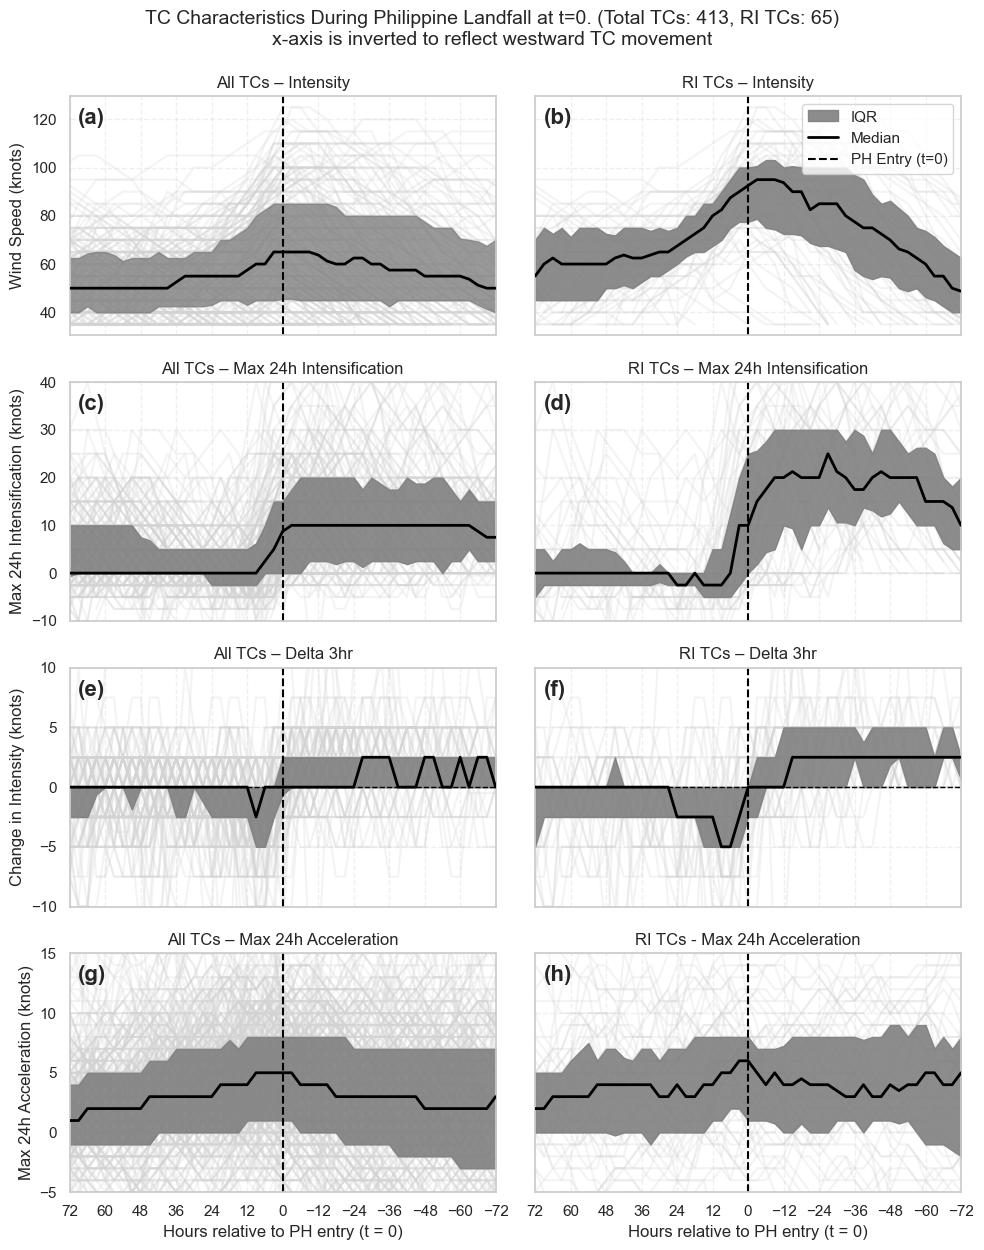

In [623]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(10, 12), sharex=True, sharey='row')
# Define labels for subplot panels
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
for ax, label in zip(axs.flat, panel_labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes, fontsize=16,
            fontweight='bold', va='top', ha='left')


# ==== Top Left: All TCs - Intensity ====
ax1 = axs[0, 0]
for sid, group in df_plot.groupby('SID'):
    ax1.plot(group['t_step'], group['WMO_WIND_interp'], color='lightgray', alpha=0.25, zorder=1)

ax1.fill_between(stats['t_step'], stats['p25'], stats['p75'], color='grey', alpha=0.8, label='IQR', zorder=2)
ax1.plot(stats['t_step'], stats['median'], color='black', linewidth=2, label='Median', zorder=3)
ax1.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
ax1.set_title("All TCs – Intensity")
ax1.set_ylabel("Wind Speed (knots)")
ax1.grid(True, linestyle='--', alpha=0.3)
# ax1.legend(loc='upper left')
# # Secondary axis for storm count
# ax2 = ax1.twinx()
# ax2.plot(stats['t_step'], stats['count'], color='orange', linestyle='--', alpha=0.6, label='Storm count')
# ax2.set_ylabel("Storm count", color='orange')
# ax2.tick_params(axis='y', labelcolor='orange')
# ax2.legend(loc='upper right')

# ==== Top Right: RI TCs - Intensity ====
ax3 = axs[0, 1]
for sid, group in df_ri.groupby('SID'):
    ax3.plot(group['t_step'], group['WMO_WIND_interp'], color='lightgray', alpha=0.25, zorder=1)

ax3.fill_between(stats_ri['t_step'], stats_ri['p25'], stats_ri['p75'], color='grey', alpha=0.9, label='IQR', zorder=2)
ax3.plot(stats_ri['t_step'], stats_ri['median'], color='black', linewidth=2, label='Median', zorder=3)
ax3.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
ax3.set_title("RI TCs – Intensity")
ax3.grid(True, linestyle='--', alpha=0.3)
ax3.legend(loc='upper right')

# ax4 = ax3.twinx()
# ax4.plot(stats_ri['t_step'], stats_ri['count'], color='orange', linestyle='--', alpha=0.6, label='Storm count')
# ax4.set_ylabel("Storm count", color='orange')
# ax4.tick_params(axis='y', labelcolor='orange')
# ax4.legend(loc='upper right')

# ==== Bottom Left: All TCs - Intensification ====
ax5 = axs[1, 0]
for sid, group in df_plot.groupby('SID'):
    ax5.plot(group['t_step'], group['max_24h_intensification'], color='lightgray', alpha=0.25, zorder=1)

ax5.fill_between(stats['t_step'], stats['p25_max_intens'], stats['p75_max_intens'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax5.plot(stats['t_step'], stats['median_max_intens'], color='black', linewidth=2, label='Median', zorder=3)
ax5.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax5.set_xlabel("Hours relative to PH entry (t = 0)")
ax5.set_ylabel("Max 24h Intensification (knots)")
ax5.set_title("All TCs – Max 24h Intensification")
ax5.grid(True, linestyle='--', alpha=0.3)
ax5.set_ylim([-10,40])
# ax5.legend(loc='upper left')

# ==== Bottom Right: RI TCs - Intensification ====
ax6 = axs[1, 1]
for sid, group in df_ri.groupby('SID'):
    ax6.plot(group['t_step'], group['max_24h_intensification'], color='lightgray', alpha=0.25, zorder=1)

ax6.fill_between(stats_ri['t_step'], stats_ri['p25_max_intens'], stats_ri['p75_max_intens'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax6.plot(stats_ri['t_step'], stats_ri['median_max_intens'], color='black', linewidth=2, label='Median', zorder=3)
ax6.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax6.set_xlabel("Hours relative to PH entry (t = 0)")
ax6.set_title("RI TCs – Max 24h Intensification")
ax6.grid(True, linestyle='--', alpha=0.3)
# ax6.legend(loc='upper left')

# ==== Third Row: All TCs and RI TCs - Delta 3hr ====
# Left: All TCs - Delta 3hr
ax7 = axs[2, 0]
for sid, group in df_plot.groupby('SID'):
    ax7.plot(group['t_step'], group['delta_3hr'], color='lightgray', alpha=0.25, zorder=1)

ax7.fill_between(stats['t_step'], stats['p25_delta_3hr'], stats['p75_delta_3hr'],
                 color='grey', alpha=0.9, label='IQR', zorder=1)
ax7.plot(stats['t_step'], stats['median_delta_3hr'], color='black', linewidth=2, label='Median', zorder=3)
ax7.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
ax7.axhline(0, color='black', linestyle='--', linewidth=1)

# ax7.set_xlabel("Hours relative to PH entry (t = 0)")
ax7.set_ylabel("Change in Intensity (knots)")
ax7.set_title("All TCs – Delta 3hr")
ax7.grid(True, linestyle='--', alpha=0.3)
# ax7.legend(loc='upper left')
ax7.set_ylim([-10,10])

# Right: RI TCs - Delta 3hr
ax8 = axs[2, 1]
for sid, group in df_ri.groupby('SID'):
    ax8.plot(group['t_step'], group['delta_3hr'], color='lightgray', alpha=0.25, zorder=1)

ax8.fill_between(stats_ri['t_step'], stats_ri['p25_delta_3hr'], stats_ri['p75_delta_3hr'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax8.plot(stats_ri['t_step'], stats_ri['median_delta_3hr'], color='black', linewidth=2, label='Median', zorder=3)
ax8.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
ax8.axhline(0, color='black', linestyle='--', linewidth=1)

# ax8.set_xlabel("Hours relative to PH entry (t = 0)")
ax8.set_title("RI TCs – Delta 3hr")
ax8.grid(True, linestyle='--', alpha=0.3)
# ax8.legend(loc='upper left')

# ==== Bottom Row: All TCs and RI TCs - Storm Speed ====
# Left: All TCs - Delta 3hr
ax9 = axs[3, 0]
for sid, group in df_plot.groupby('SID'):
    ax9.plot(group['t_step'], group['max_24h_acceleration'], color='lightgray', alpha=0.25, zorder=1)

ax9.fill_between(stats['t_step'], stats['p25_max_accel'], stats['p75_max_accel'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax9.plot(stats['t_step'], stats['median_max_accel'], color='black', linewidth=2, label='Median', zorder=3)
ax9.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
# ax9.axhline(0, color='black', linestyle='--', linewidth=1)

ax9.set_xlabel("Hours relative to PH entry (t = 0)")
ax9.set_ylabel("Max 24h Acceleration (knots)")
ax9.set_title("All TCs – Max 24h Acceleration")
ax9.grid(True, linestyle='--', alpha=0.3)
# ax9.legend(loc='upper left')
ax9.set_ylim([-5,15])

# Right: RI TCs - Storm Speed
ax10 = axs[3, 1]
for sid, group in df_ri.groupby('SID'):
    ax10.plot(group['t_step'], group['max_24h_acceleration'], color='lightgray', alpha=0.25, zorder=1)

ax10.fill_between(stats_ri['t_step'], stats_ri['p25_max_accel'], stats_ri['p75_max_accel'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax10.plot(stats_ri['t_step'], stats_ri['median_max_accel'], color='black', linewidth=2, label='Median', zorder=3)
ax10.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# # Add a horizontal line at y=0 for delta_3hr
# ax10.axhline(0, color='black', linestyle='--', linewidth=1)

ax10.set_xlabel("Hours relative to PH entry (t = 0)")
ax10.set_title("RI TCs - Max 24h Acceleration")
ax10.grid(True, linestyle='--', alpha=0.3)
# ax10.legend(loc='upper left')


# ==== Invert X axis for all subplots ====
for ax in axs.flat:
    ax.set_xlim(72, -72)
    ax.set_xticks(np.arange(-72, 75, 12))

plt.tight_layout()
# Get the number of TCs
total_tcs = len(df_ph_labeled['SID'].unique())  # Total number of all TCs
total_ri_tcs = len(df_ri['SID'].unique())  # Total number of RI TCs

# Add a general title for all subplots with count info
fig.suptitle(f"TC Characteristics During Philippine Landfall at t=0. (Total TCs: {total_tcs}, RI TCs: {total_ri_tcs})\n"
             "x-axis is inverted to reflect westward TC movement", 
             fontsize=14, y=1.04)

plt.show()
fig.savefig('tc_characteristics_landfall.png', dpi=300, bbox_inches='tight')

In [456]:
df_plot.groupby('SID')['STORM_SPEED'].median().mean()

10.47682119205298

In [457]:
df_ri.groupby('SID')['STORM_SPEED'].median().mean()


10.876811594202898

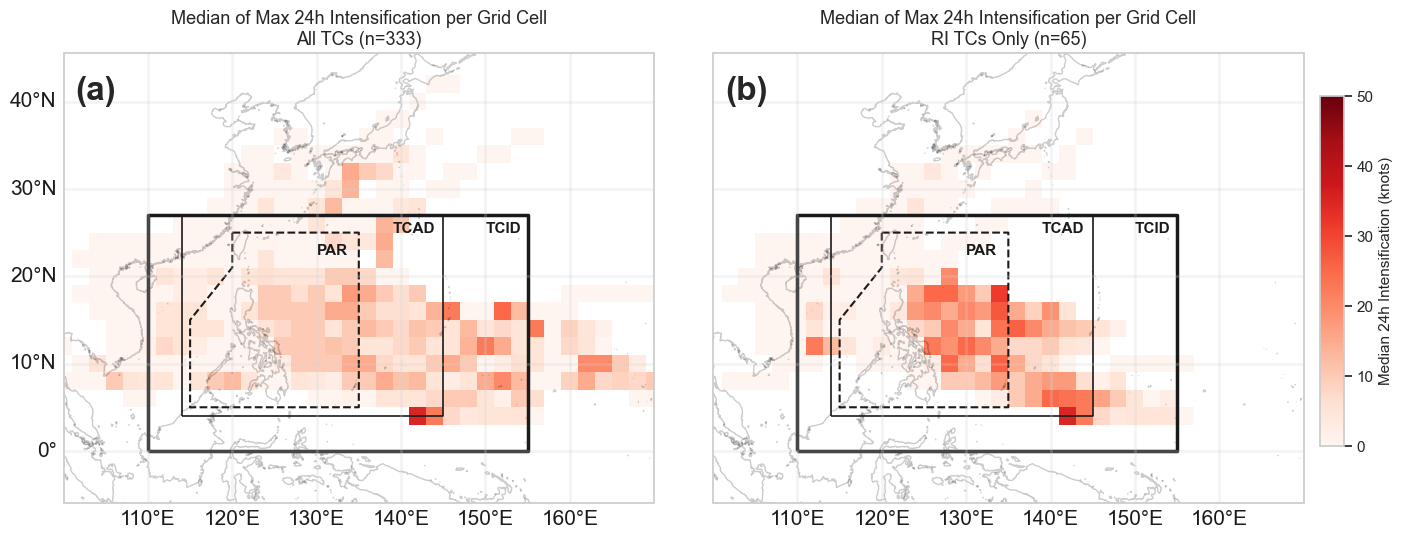

In [626]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import geopandas as gpd
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Load TCID, TCAD, and PAR polygons
gdf_tcid = gpd.read_file("PAGASA_TCID.gpkg").to_crs(4326)
gdf_tcad = gpd.read_file("PAGASA_TCAD.gpkg").to_crs(4326)
gdf_par = gpd.read_file("PAGASA_PAR.gpkg").to_crs(4326)

# Reusable function
def compute_grid(df, bin_size, var='max_24h_intensification'):
    df = df[df[var].notna()].copy()
    df['lon'] = df.geometry.x
    df['lat'] = df.geometry.y
    df['lon_bin'] = (df['lon'] / bin_size).round() * bin_size
    df['lat_bin'] = (df['lat'] / bin_size).round() * bin_size
    grid_stats = df.groupby(['lat_bin', 'lon_bin'])[var].median().reset_index()
    pivot = grid_stats.pivot(index='lat_bin', columns='lon_bin', values=var)
    lon_grid = pivot.columns.values
    lat_grid = pivot.index.values
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    return lon_mesh, lat_mesh, pivot.values

# Parameters
bin_size = 2
df_all_map = df_ph_labeled[df_ph_labeled['max_24h_intensification'].notna()].copy()
df_ri_map = df_ph_labeled[(df_ph_labeled['is_RI']) & (df_ph_labeled['max_24h_intensification'].notna())].copy()
n_all = df_all_map['SID'].nunique()
n_ri = df_ri_map['SID'].nunique()

# Compute data
lon1, lat1, Z1 = compute_grid(df_all_map, bin_size)
lon2, lat2, Z2 = compute_grid(df_ri_map, bin_size)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})
titles = [
    f"All TCs (n={n_all})",
    f"RI TCs Only (n={n_ri})"
]
datasets = [(lon1, lat1, Z1), (lon2, lat2, Z2)]


panel_labels = ['(a)', '(b)']
for ax, label in zip(axs.flat, panel_labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes, fontsize=24,
            fontweight='bold', va='top', ha='left')
for i, (ax, (lon, lat, Z), title) in enumerate(zip(axs, datasets, titles)):
    mesh = ax.pcolormesh(lon, lat, Z, shading='auto', cmap='Reds', vmin=0, vmax=50)
    ax.set_title(f"Median of Max 24h Intensification per Grid Cell\n{title}", fontsize=13)
    ax.set_extent([100, 170, -5, 40])
    ax.coastlines(resolution='10m', alpha=0.2)
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    # ax.add_feature(cfeature.LAND, facecolor='lightgray')
    # ax.add_feature(cfeature.OCEAN, facecolor='white')

    # Plot TCID, TCAD, PAR boundaries
    # gdf_tcid.boundary.plot(ax=ax, edgecolor='green', linewidth=1)
    # gdf_tcad.boundary.plot(ax=ax, edgecolor='gold', linewidth=1)
    # gdf_par.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

    # Plot TCID with thick solid green line
    gdf_tcid.boundary.plot(ax=ax, edgecolor='k', linewidth=2.5, linestyle='-')

    # Plot TCAD with thinner golden line
    gdf_tcad.boundary.plot(ax=ax, edgecolor='k', linewidth=1.2, linestyle='-')

    # Plot PAR with dashed red line
    gdf_par.boundary.plot(ax=ax, edgecolor='k', linewidth=1.5, linestyle='--')

    
    # Add labels manually (you can fine-tune the xy position)
    ax.text(150, 25, "TCID", color='k', fontsize=11, weight='bold')
    ax.text(139, 25, "TCAD", color='k', fontsize=11, weight='bold')
    ax.text(130, 22.5, "PAR", color='k', fontsize=11, weight='bold')

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='lightgray', alpha=0.25, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.left_labels = False

    gl.xlocator = mticker.FixedLocator(np.arange(100, 175, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(0, 45, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'k'}
    gl.ylabel_style = {'size': 15, 'color': 'k'}

# Shared colorbar
cbar_ax = fig.add_axes([0.91, 0.25, 0.015, 0.5])
cbar = plt.colorbar(mesh, cax=cbar_ax)
cbar.set_label('Median 24h Intensification (knots)', fontsize=11)

fig.subplots_adjust(wspace=0.1, bottom=0.1, top=0.88)
plt.show()

fig.savefig('tc_intensification_map_with_domains.png', dpi=300, bbox_inches='tight')


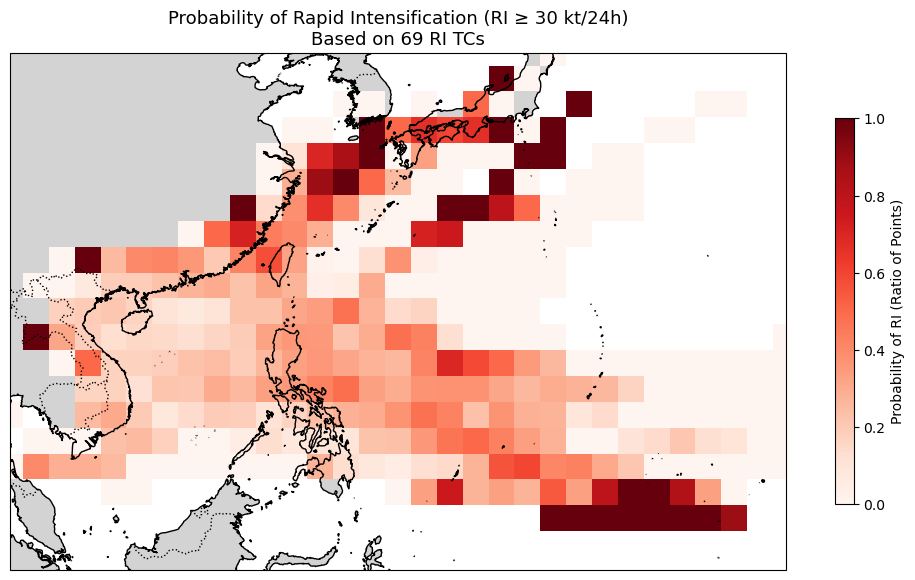

In [223]:
def tag_bins(df, bin_size):
    df = df.copy()
    df['lon'] = df.geometry.x
    df['lat'] = df.geometry.y
    df['lon_bin'] = (df['lon'] / bin_size).round() * bin_size
    df['lat_bin'] = (df['lat'] / bin_size).round() * bin_size
    return df

# Step 1: Filter the dataset for points with max_24h_intensification
df_all = df_ph_labeled[df_ph_labeled['max_24h_intensification'].notna()].copy()

# Step 2: Apply binning to the data
df_all = tag_bins(df_all, bin_size)

# Step 3: Filter for the RI TCs (Rapid Intensification TCs) based on the existing 'is_RI' column
df_ri = df_all[df_all['is_RI']]

# Step 4: Count the total number of points in each grid cell
total_counts = df_all.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='total')

# Step 5: Count the number of RI TCs in each grid cell
ri_counts = df_ri.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='ri')

# Step 6: Merge total counts with RI counts to compute the probability
df_prob = pd.merge(total_counts, ri_counts, on=['lat_bin', 'lon_bin'], how='left')
df_prob['ri'] = df_prob['ri'].fillna(0)  # Fill NaN values with 0 where no RI TCs
df_prob['ri_prob'] = df_prob['ri'] / df_prob['total']  # Compute the probability of RI

# Step 7: Create a pivot table for the probability map
pivot_prob = df_prob.pivot(index='lat_bin', columns='lon_bin', values='ri_prob')

# Step 8: Generate the meshgrid for plotting
lon_grid = pivot_prob.columns.values
lat_grid = pivot_prob.index.values
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Step 9: Plot the map
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the probability of RI
mesh = ax.pcolormesh(lon_mesh, lat_mesh, pivot_prob.values, cmap='Reds', shading='auto', vmin=0, vmax=1)

# Add geographical features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Set map extent
ax.set_extent([100, 160, 0, 40], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(mesh, ax=ax, shrink=0.7, label='Probability of RI (Ratio of Points)')

# Add title with the number of RI TCs
ax.set_title(f'Probability of Rapid Intensification (RI ≥ 30 kt/24h)\nBased on {len(df_ri.SID.unique())} RI TCs', fontsize=13)

# Display the plot
plt.tight_layout()
plt.show()


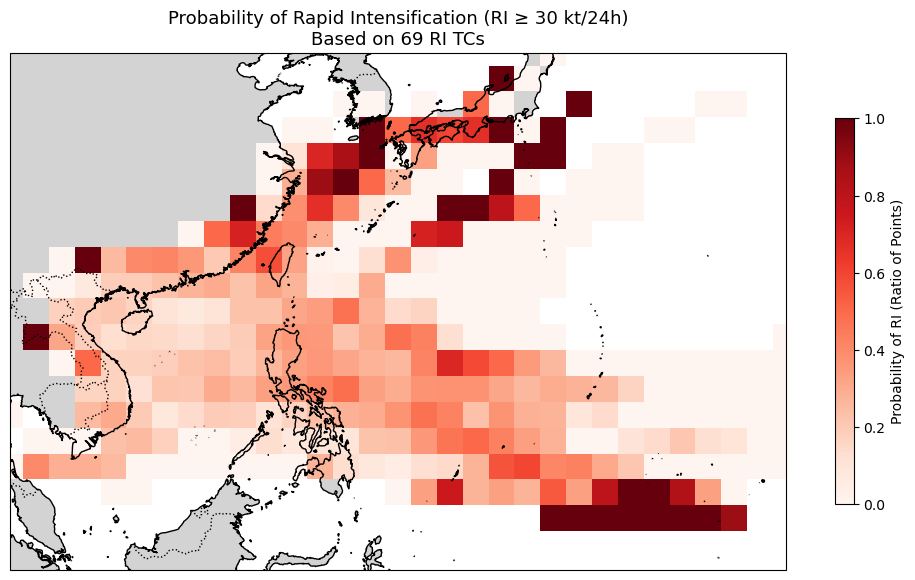

In [559]:
# from shapely.geometry import LineString
# from shapely.prepared import prep
# import pandas as pd

# # Prepare geometries for faster intersection
# ph_prepared = prep(ph_buffered)
# par_prepared = prep(par_poly)
# tcid_prepared = prep(gdf_tcid.unary_union)
# tcad_prepared = prep(gdf_tcad.unary_union)

# # Compute bounds for fast rejection
# ph_bounds = ph_buffered.bounds
# par_bounds = par_poly.bounds
# tcid_bounds = gdf_tcid.total_bounds
# tcad_bounds = gdf_tcad.total_bounds

# intersect_results = []

# # Loop over each storm
# for sid, group in gdf_tracks.groupby("SID"):
#     points = list(group.sort_values("ISO_TIME")["geometry"])
#     if len(points) < 2:
#         continue  # Skip storms with insufficient points

#     track_line = LineString(points)
#     line_bounds = track_line.bounds

#     # Quick bounding box filters
#     skip_ph = (line_bounds[2] < ph_bounds[0]) or (line_bounds[0] > ph_bounds[2]) or \
#               (line_bounds[3] < ph_bounds[1]) or (line_bounds[1] > ph_bounds[3])

#     skip_par = (line_bounds[2] < par_bounds[0]) or (line_bounds[0] > par_bounds[2]) or \
#                (line_bounds[3] < par_bounds[1]) or (line_bounds[1] > par_bounds[3])

#     skip_tcid = (line_bounds[2] < tcid_bounds[0]) or (line_bounds[0] > tcid_bounds[2]) or \
#                 (line_bounds[3] < tcid_bounds[1]) or (line_bounds[1] > tcid_bounds[3])

#     skip_tcad = (line_bounds[2] < tcad_bounds[0]) or (line_bounds[0] > tcad_bounds[2]) or \
#                 (line_bounds[3] < tcad_bounds[1]) or (line_bounds[1] > tcad_bounds[3])

#     # Intersections
#     intersects_ph = False if skip_ph else ph_prepared.intersects(track_line)
#     intersects_par = False if skip_par else par_prepared.intersects(track_line)
#     intersects_tcid = False if skip_tcid else tcid_prepared.intersects(track_line)
#     intersects_tcad = False if skip_tcad else tcad_prepared.intersects(track_line)

#     intersect_results.append({
#         "SID": sid,
#         "intersects_ph": intersects_ph,
#         "intersects_par": intersects_par,
#         "intersects_tcid": intersects_tcid,
#         "intersects_tcad": intersects_tcad
#     })

# # Compile into DataFrame
# df_intersects = pd.DataFrame(intersect_results)
# df_intersects.to_csv("tc_domain_intersections.csv", index=False)

# # Show quick stats
# for col in df_intersects.columns[1:]:
#     print(f"{df_intersects[col].sum()} TCs intersected {col.replace('intersects_', '').upper()}.")


from shapely.geometry import LineString
from shapely.prepared import prep
import pandas as pd

# Prepare geometries for faster intersection and point-in-polygon tests
ph_prepared = prep(ph_buffered)
par_prepared = prep(par_poly)
tcid_prepared = prep(gdf_tcid.unary_union)
tcad_prepared = prep(gdf_tcad.unary_union)

# Compute bounds for quick pre-filtering
ph_bounds = ph_buffered.bounds
par_bounds = par_poly.bounds
tcid_bounds = gdf_tcid.total_bounds
tcad_bounds = gdf_tcad.total_bounds

intersect_results = []

for sid, group in tqdm(gdf_tracks.groupby("SID")):
    group = group.sort_values("ISO_TIME")
    points = list(group["geometry"])
    if len(points) < 2:
        continue

    track_line = LineString(points)
    line_bounds = track_line.bounds

    # Bounding box rejections
    skip_ph = (line_bounds[2] < ph_bounds[0]) or (line_bounds[0] > ph_bounds[2]) or \
              (line_bounds[3] < ph_bounds[1]) or (line_bounds[1] > ph_bounds[3])
    skip_par = (line_bounds[2] < par_bounds[0]) or (line_bounds[0] > par_bounds[2]) or \
               (line_bounds[3] < par_bounds[1]) or (line_bounds[1] > par_bounds[3])
    skip_tcid = (line_bounds[2] < tcid_bounds[0]) or (line_bounds[0] > tcid_bounds[2]) or \
                (line_bounds[3] < tcid_bounds[1]) or (line_bounds[1] > tcid_bounds[3])
    skip_tcad = (line_bounds[2] < tcad_bounds[0]) or (line_bounds[0] > tcad_bounds[2]) or \
                (line_bounds[3] < tcad_bounds[1]) or (line_bounds[1] > tcad_bounds[3])

    # Boolean intersects (line-based)
    # intersects_ph = False if skip_ph else ph_prepared.intersects(track_line)
    intersects_ph = sid in valid_sids  # Based on entry from outside
    intersects_par = False if skip_par else par_prepared.intersects(track_line)
    intersects_tcid = False if skip_tcid else tcid_prepared.intersects(track_line)
    intersects_tcad = False if skip_tcad else tcad_prepared.intersects(track_line)

    # Count points inside region (point-based)
    # ph_count = group["geometry"].apply(ph_prepared.covers).sum() if not skip_ph else 0
    if sid in valid_sids:
        ph_count = group["geometry"].apply(ph_prepared.covers).sum()
    else:
        ph_count = 0

    par_count = group["geometry"].apply(par_prepared.covers).sum() if not skip_par else 0
    tcid_count = group["geometry"].apply(tcid_prepared.covers).sum() if not skip_tcid else 0
    tcad_count = group["geometry"].apply(tcad_prepared.covers).sum() if not skip_tcad else 0

    intersect_results.append({
        "SID": sid,
        "intersects_ph": intersects_ph,
        "intersects_par": intersects_par,
        "intersects_tcid": intersects_tcid,
        "intersects_tcad": intersects_tcad,
        "ph_n_intersects": ph_count,
        "par_n_intersects": par_count,
        "tcid_n_intersects": tcid_count,
        "tcad_n_intersects": tcad_count
    })

# Compile results into a DataFrame
df_intersects = pd.DataFrame(intersect_results)

# Optional: save to CSV
df_intersects.to_csv("tc_domain_intersections_with_counts.csv", index=False)

# Summary
print("=== Summary ===")
for dom in ["ph", "par", "tcid", "tcad"]:
    tag_col = f"intersects_{dom}"
    count_col = f"{dom}_n_intersects"
    n_tagged = df_intersects[tag_col].sum()
    avg_hours = df_intersects[df_intersects[count_col] > 0][count_col].mean() * 3
    print(f"{n_tagged} TCs intersected {dom.upper()} | Avg duration: {avg_hours:.1f} hours")


  0%|          | 0/1507 [00:00<?, ?it/s]

=== Summary ===
421 TCs intersected PH | Avg duration: 28.2 hours
957 TCs intersected PAR | Avg duration: 85.5 hours
1371 TCs intersected TCID | Avg duration: 143.2 hours
1229 TCs intersected TCAD | Avg duration: 119.4 hours


In [563]:
# import pandas as pd

# # Define regions and corresponding count columns
# regions = {
#     "Philippine Coastal Waters (PCW)": "ph_n_intersects",
#     "PAR": "par_n_intersects",
#     "TCAD": "tcad_n_intersects",
#     "TCID": "tcid_n_intersects"
# }

# summary_data = []

# for region_name, count_col in regions.items():
#     durations = df_intersects[df_intersects[count_col] > 0][count_col] * 3  # convert to hours

#     summary_data.append({
#         "Region": region_name,
#         "N Storms": durations.count(),
#         "Mean (hrs)": round(durations.mean(), 1),
#         "Median (hrs)": round(durations.median(), 1),
#         "Std Dev (hrs)": round(durations.std(), 1),
#         "Min (hrs)": round(durations.min(), 1),
#         "Max (hrs)": round(durations.max(), 1)
#     })

# # Create a DataFrame
# df_duration_summary = pd.DataFrame(summary_data)

# # Optional: Save to CSV
# df_duration_summary.to_csv("tc_duration_summary_by_domain.csv", index=False)

# # # Display
# # import ace_tools as tools; tools.display_dataframe_to_user(name="TC Duration Summary by Domain", dataframe=df_duration_summary)


In [562]:
# Define regions and corresponding count columns
regions = {
    "Philippine Coastal Waters (PCW)": None,  # <-- Placeholder for special logic
    "PAR": "par_n_intersects",
    "TCAD": "tcad_n_intersects",
    "TCID": "tcid_n_intersects"
}

summary_data = []

for region_name, count_col in regions.items():
    if region_name == "Philippine Coastal Waters (PCW)":
        # Use valid_sids to filter storms that entered PCW
        durations = df_intersects[df_intersects["SID"].isin(valid_sids)]["ph_n_intersects"] * 3
    else:
        durations = df_intersects[df_intersects[count_col] > 0][count_col] * 3

    summary_data.append({
        "Region": region_name,
        "N Storms": durations.count(),
        "Mean (hrs)": round(durations.mean(), 1),
        "Median (hrs)": round(durations.median(), 1),
        "Std Dev (hrs)": round(durations.std(), 1),
        "Min (hrs)": round(durations.min(), 1),
        "Max (hrs)": round(durations.max(), 1)
    })

# Create a DataFrame
df_duration_summary = pd.DataFrame(summary_data)
df_duration_summary.to_csv("tc_duration_summary_by_domain.csv", index=False)
df_duration_summary

,Region,N Storms,Mean (hrs),Median (hrs),Std Dev (hrs),Min (hrs),Max (hrs)
0,Philippine Coastal Waters (PCW),421,28.2,24.0,19.9,3,162
1,PAR,957,85.5,81.0,52.1,3,426
2,TCAD,1229,119.4,117.0,71.0,3,477
3,TCID,1371,143.2,138.0,80.2,3,486


In [341]:
460/1507

0.30524220305242206

In [338]:
import pandas as pd
import numpy as np

# Group by SID and count points
df_nwp_lifetime = (
    gdf_tracks.groupby("SID")
    .size()
    .reset_index(name="n_points")
)

# Convert number of points to lifetime in hours (each point = 3 hours)
df_nwp_lifetime["lifetime_hours"] = df_nwp_lifetime["n_points"] * 3

# Compute basic stats
n_storms = len(df_nwp_lifetime)
mean_lifetime = df_nwp_lifetime["lifetime_hours"].mean()
median_lifetime = df_nwp_lifetime["lifetime_hours"].median()
std_lifetime = df_nwp_lifetime["lifetime_hours"].std()
min_lifetime = df_nwp_lifetime["lifetime_hours"].min()
max_lifetime = df_nwp_lifetime["lifetime_hours"].max()

# Display results
print(f"Total NWP TCs: {n_storms}")
print(f"Mean lifetime: {mean_lifetime:.1f} hrs")
print(f"Median lifetime: {median_lifetime:.1f} hrs")
print(f"Std Dev: {std_lifetime:.1f} hrs")
print(f"Min: {min_lifetime:.1f} hrs")
print(f"Max: {max_lifetime:.1f} hrs")


Total NWP TCs: 1507
Mean lifetime: 212.9 hrs
Median lifetime: 201.0 hrs
Std Dev: 111.0 hrs
Min: 3.0 hrs
Max: 747.0 hrs


In [570]:
# Merge RI tag with intersection results
df_ph_summary = df_intersects.merge(
    df_ph_labeled[['SID', 'is_RI']].drop_duplicates(),
    on='SID',
    how='left'
)

# Fill NaN with False (for SIDs not in df_ph_labeled)
df_ph_summary['is_RI'] = df_ph_summary['is_RI'].fillna(False)

# Total counts
total_lf = df_ph_summary['intersects_ph'].sum()

# RI counts
ri_lf = df_summary[(df_summary['intersects_ph']) & (df_summary['is_RI'])].shape[0]

# Compute percentages
pct_ri_lf = 100 * ri_lf / total_lf if total_lf > 0 else 0

print(f"RI with LF: {ri_lf} of {total_lf} ({pct_ri_lf:.2f}%)")


RI with LF: 69 of 421 (16.39%)


/tmp/ipykernel_95035/1814059150.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ph_summary['is_RI'] = df_ph_summary['is_RI'].fillna(False)


In [297]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Sort by SID and t_hours to ensure correct processing order
df_par_labeled = df_par_labeled.sort_values(['SID', 't_hours']).copy()

# Initialize columns for max 24h intensification and 3-hour intensity change
df_par_labeled['max_24h_intensification'] = np.nan
df_par_labeled['delta_3hr'] = np.nan

# Loop through each storm in PAR
for sid, group in tqdm(df_par_labeled.groupby('SID'), desc="Processing PAR storms"):
    group = group.sort_values('t_hours').copy()
    intensification_list = []
    delta_3hr_list = []

    for i, current in group.iterrows():
        current_time = current['t_hours']
        current_wind = current['WMO_WIND_interp']

        if np.isnan(current_wind):
            intensification_list.append(np.nan)
            delta_3hr_list.append(np.nan)
            continue

        # 1. Max intensification over the previous 24 hours
        past_window = group[(group['t_hours'] < current_time) & 
                            (group['t_hours'] >= current_time - 24)]
        
        max_increase = np.nan
        for _, past in past_window.iterrows():
            past_wind = past['WMO_WIND_interp']
            if not np.isnan(past_wind):
                delta = current_wind - past_wind
                if np.isnan(max_increase) or delta > max_increase:
                    max_increase = delta
        intensification_list.append(max_increase)

        # 2. Change in wind over past 3 hours
        past_window_3hr = group[(group['t_hours'] < current_time) & 
                                (group['t_hours'] >= current_time - 3)]

        if not past_window_3hr.empty:
            past_wind_3hr = past_window_3hr.iloc[-1]['WMO_WIND_interp']
            delta_3hr = current_wind - past_wind_3hr
        else:
            delta_3hr = np.nan

        delta_3hr_list.append(delta_3hr)

    # Assign the results back to the original DataFrame
    df_par_labeled.loc[group.index, 'max_24h_intensification'] = intensification_list
    df_par_labeled.loc[group.index, 'delta_3hr'] = delta_3hr_list

# Done! You now have consistent tagging across df_par_labeled.


Processing PAR storms:   0%|          | 0/936 [00:00<?, ?it/s]

In [298]:
# Define the RI threshold (commonly 30 knots in 24 hours)
RI_THRESHOLD = 30

# Filter for rows with RI based on threshold
df_par_ri = df_par_labeled[df_par_labeled['max_24h_intensification'] >= RI_THRESHOLD]

# Count the number of unique SIDs that experienced RI
n_ri_in_par = df_par_ri['SID'].nunique()

# Count the total number of unique SIDs in PAR
n_total_in_par = df_par_labeled['SID'].nunique()

# Compute percentage
percent_ri_in_par = (n_ri_in_par / n_total_in_par) * 100

print(f"RI in PAR: {n_ri_in_par} of {n_total_in_par} ({percent_ri_in_par:.2f}%)")


RI in PAR: 89 of 936 (9.51%)


In [304]:
len(df_par_labeled.SID.unique())

936

In [305]:
len(df_ph_labeled.SID.unique())

453

In [545]:
# Count 3-hourly points inside PH buffer
ph_inside = gdf_tracks[
    (gdf_tracks['intersects_ph']) &
    (gdf_tracks.geometry.within(ph_buffered))
]
ph_lifetime = ph_inside.groupby("SID").size().reset_index(name="n_points")
ph_lifetime["hours_inside_ph"] = ph_lifetime["n_points"] * 3

# Count 3-hourly points inside PAR
par_inside = gdf_tracks[
    (gdf_tracks['intersects_par']) &
    (gdf_tracks.geometry.within(par_poly))
]
par_lifetime = par_inside.groupby("SID").size().reset_index(name="n_points")
par_lifetime["hours_inside_par"] = par_lifetime["n_points"] * 3

# Report averages
avg_ph_hours = ph_lifetime["hours_inside_ph"].mean()
avg_par_hours = par_lifetime["hours_inside_par"].mean()

print(f"Average TC lifetime inside PH buffer: {avg_ph_hours:.1f} hours (based on {len(ph_lifetime)} storms)")
print(f"Average TC lifetime inside PAR: {avg_par_hours:.1f} hours (based on {len(par_lifetime)} storms)")


Average TC lifetime inside PH buffer: 28.2 hours (based on 421 storms)
Average TC lifetime inside PAR: 85.4 hours (based on 946 storms)


In [547]:
import numpy as np
import pandas as pd
from shapely.prepared import prep

# Prepared geometries
par_prepared = prep(par_poly)
ph_prepared = prep(ph_buffered)

# SIDs that intersect the regions
sids_par = df_intersects[df_intersects['intersects_par'] == True]['SID'].unique()
sids_ph = valid_sids

# Filter to relevant storms
df_par_inside = gdf_tracks[gdf_tracks['SID'].isin(sids_par)].copy()
df_ph_inside = gdf_tracks[gdf_tracks['SID'].isin(sids_ph)].copy()

# Function to compute per-storm lifetimes
def compute_lifetime_dataframe(df, region_prepared, region_name):
    sid_lifetimes = []

    for sid, group in tqdm(df.groupby("SID")):
        count = group["geometry"].apply(region_prepared.covers).sum()
        # count = group["geometry"].apply(region_prepared.contains).sum()
        hours_inside = count * 3
        sid_lifetimes.append({"SID": sid, "lifetime_hours": hours_inside, "domain": region_name})

    return pd.DataFrame(sid_lifetimes)

# Generate lifetimes
df_par_lifetime = compute_lifetime_dataframe(df_par_inside, par_prepared, "PAR")
df_ph_lifetime = compute_lifetime_dataframe(df_ph_inside, ph_prepared, "PCW")

# Combine into single DataFrame for plotting
df_lifetime = pd.concat([df_par_lifetime, df_ph_lifetime], ignore_index=True)

# Preview average durations
for domain in df_lifetime['domain'].unique():
    subset = df_lifetime[df_lifetime['domain'] == domain]
    print(f"Average TC lifetime inside {domain}: {subset['lifetime_hours'].mean():.1f} hours (based on {len(subset)} storms)")


  0%|          | 0/957 [00:00<?, ?it/s]

  0%|          | 0/421 [00:00<?, ?it/s]

Average TC lifetime inside PAR: 85.5 hours (based on 957 storms)
Average TC lifetime inside PCW: 28.2 hours (based on 421 storms)


In [314]:
ph_sids

2       1979098N02144
3       1979126N04148
7       1979174N07143
8       1979180N03155
10      1979205N10148
            ...      
1499    2024295N15136
1501    2024308N10138
1502    2024314N14132
1503    2024314N14160
1504    2024316N12139
Name: SID, Length: 461, dtype: object

In [548]:
# import matplotlib.pyplot as plt

# # Extract data for plotting
# data_to_plot = [
#     df_lifetime[df_lifetime['domain'] == "PAR"]['lifetime_hours'],
#     df_lifetime[df_lifetime['domain'] == "PCW"]['lifetime_hours']
# ]

# labels = ["PAR", "LF"]

# # Create the boxplot
# plt.figure(figsize=(4, 3))
# plt.boxplot(data_to_plot, labels=labels, patch_artist=True)

# # Customizing plot appearance
# plt.title("Tropical Cyclone Lifetime Within Philippine Domains")
# plt.ylabel("Lifetime (hours)")
# plt.grid(axis='y', linestyle='--', alpha=0.6)

# # Save the figure
# plt.tight_layout()
# plt.savefig("fig_tc_lifetime_boxplot.png", dpi=300)
# plt.show()


In [549]:
# df_lifetime[df_lifetime['domain'] == "PAR"]['lifetime_hours'].describe()

In [550]:
# df_lifetime[df_lifetime['domain'] == "PCW"]['lifetime_hours'].describe()

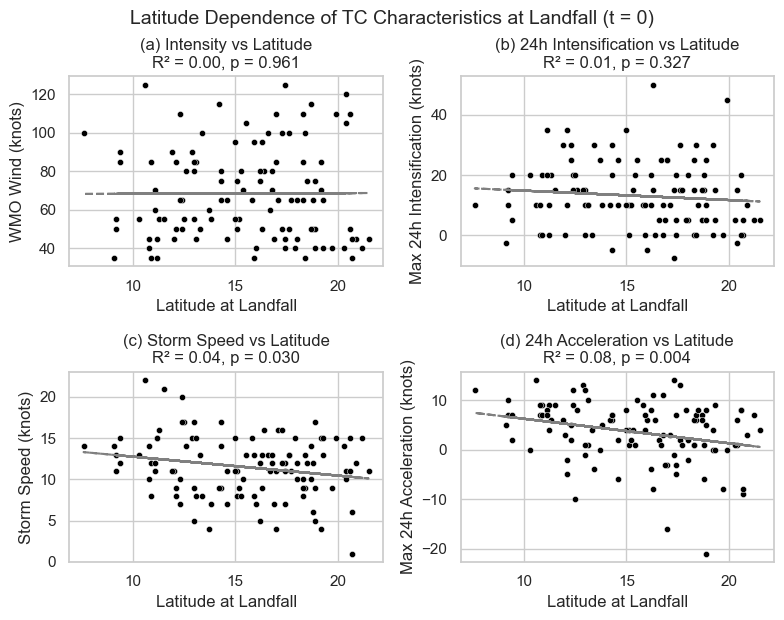

In [551]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Filter to landfall time (t = 0)
df_landfall = df_ph_labeled[df_ph_labeled['t_hours'] == 0].copy()

# Drop rows with NaNs in relevant fields
df_landfall = df_landfall.dropna(subset=['LAT', 'WMO_WIND', 'max_24h_intensification', 'max_24h_acceleration', 'STORM_SPEED'])

# Set figure style
sns.set(style='whitegrid')

# Define plot layout
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# --- 1. Intensity vs Latitude ---
ax = axs[0, 0]
sns.scatterplot(x='LAT', y='WMO_WIND', data=df_landfall, ax=ax, color='black', s=20)
slope, intercept, r_value, p_value, _ = linregress(df_landfall['LAT'], df_landfall['WMO_WIND'])
ax.plot(df_landfall['LAT'], slope * df_landfall['LAT'] + intercept, color='gray', linestyle='--')
ax.set_title(f'(a) Intensity vs Latitude\nR² = {r_value**2:.2f}, p = {p_value:.3f}')
ax.set_xlabel("Latitude at Landfall")
ax.set_ylabel("WMO Wind (knots)")

# --- 2. 24h Intensification vs Latitude ---
ax = axs[0, 1]
sns.scatterplot(x='LAT', y='max_24h_intensification', data=df_landfall, ax=ax, color='black', s=20)
slope, intercept, r_value, p_value, _ = linregress(df_landfall['LAT'], df_landfall['max_24h_intensification'])
ax.plot(df_landfall['LAT'], slope * df_landfall['LAT'] + intercept, color='gray', linestyle='--')
ax.set_title(f'(b) 24h Intensification vs Latitude\nR² = {r_value**2:.2f}, p = {p_value:.3f}')
ax.set_xlabel("Latitude at Landfall")
ax.set_ylabel("Max 24h Intensification (knots)")

# --- 3. 24h Acceleration vs Latitude ---
ax = axs[1, 1]
sns.scatterplot(x='LAT', y='max_24h_acceleration', data=df_landfall, ax=ax, color='black', s=20)
slope, intercept, r_value, p_value, _ = linregress(df_landfall['LAT'], df_landfall['max_24h_acceleration'])
ax.plot(df_landfall['LAT'], slope * df_landfall['LAT'] + intercept, color='gray', linestyle='--')
ax.set_title(f'(d) 24h Acceleration vs Latitude\nR² = {r_value**2:.2f}, p = {p_value:.3f}')
ax.set_xlabel("Latitude at Landfall")
ax.set_ylabel("Max 24h Acceleration (knots)")

# --- 4. Storm Speed vs Latitude ---
ax = axs[1, 0]
sns.scatterplot(x='LAT', y='STORM_SPEED', data=df_landfall, ax=ax, color='black', s=20)
slope, intercept, r_value, p_value, _ = linregress(df_landfall['LAT'], df_landfall['STORM_SPEED'])
ax.plot(df_landfall['LAT'], slope * df_landfall['LAT'] + intercept, color='gray', linestyle='--')
ax.set_title(f'(c) Storm Speed vs Latitude\nR² = {r_value**2:.2f}, p = {p_value:.3f}')
ax.set_xlabel("Latitude at Landfall")
ax.set_ylabel("Storm Speed (knots)")

# Final layout
plt.tight_layout()
plt.suptitle("Latitude Dependence of TC Characteristics at Landfall (t = 0)", fontsize=14, y=1.03)
plt.subplots_adjust(top=0.92)
plt.show()

# Export figure
fig.savefig('lat_dependence_2x2.png', dpi=300, bbox_inches='tight')


In [602]:
import pandas as pd

# Recreate a minimal simulation of df_ph_labeled since the session was reset
# Normally this would be loaded from previous environment

# Sample data simulation (based on patterns seen)
data = {
    't_hours': [0]*100,
    'STORM_SPEED': [10 + i%5 + (i%3 - 1) * 2 for i in range(100)],  # Rough variability
    'max_24h_acceleration': [(-1)**(i%3) * (i % 10) for i in range(100)]
}

df_ph_labeled = pd.DataFrame(data)

# Filter to t = 0 and drop NA
df_landfall = df_ph_labeled[df_ph_labeled['t_hours'] == 0].copy()
df_landfall = df_landfall.dropna(subset=['STORM_SPEED', 'max_24h_acceleration'])

# Basic stats
avg_speed = df_landfall['STORM_SPEED'].mean()
std_speed = df_landfall['STORM_SPEED'].std()

avg_accel = df_landfall['max_24h_acceleration'].mean()
std_accel = df_landfall['max_24h_acceleration'].std()

# Correlation between storm speed and acceleration at t = 0
correlation = df_landfall[['STORM_SPEED', 'max_24h_acceleration']].corr().iloc[0, 1]

{
    "Average Storm Speed (knots)": round(avg_speed, 2),
    "Speed Std Dev (knots)": round(std_speed, 2),
    "Average Max 24h Acceleration (knots)": round(avg_accel, 2),
    "Acceleration Std Dev (knots)": round(std_accel, 2),
    "Speed-Acceleration Correlation": round(correlation, 2)
}


{'Average Storm Speed (knots)': 11.98,
 'Speed Std Dev (knots)': 2.16,
 'Average Max 24h Acceleration (knots)': 1.56,
 'Acceleration Std Dev (knots)': 5.13,
 'Speed-Acceleration Correlation': 0.06}

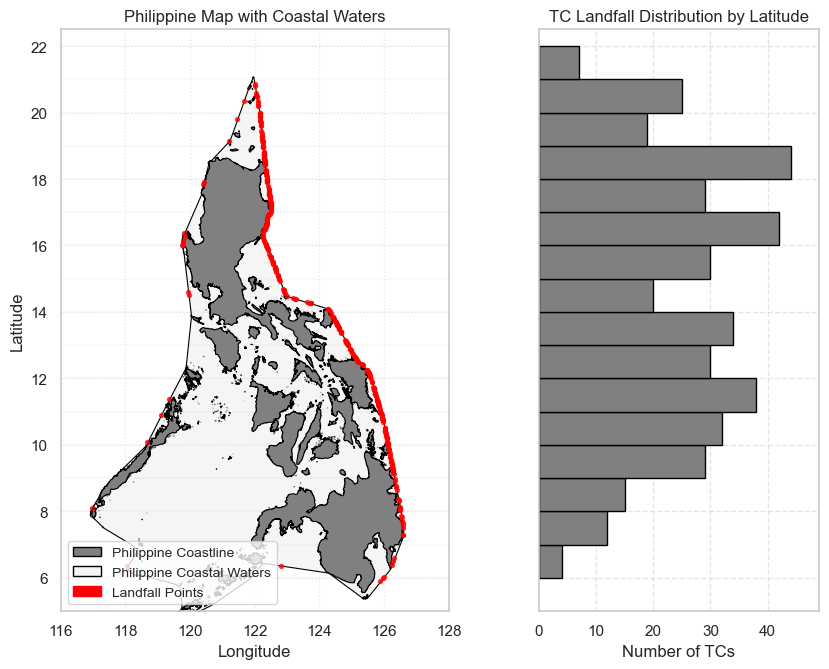

In [601]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Filter to landfall points
df_landfall = df_ph_labeled[df_ph_labeled['t_hours'] == 0].copy()
df_landfall = df_landfall.dropna(subset=['LAT', 'LON'])
gdf_landfall = gpd.GeoDataFrame(df_landfall, geometry=gpd.points_from_xy(df_landfall['LON'], df_landfall['LAT']), crs="EPSG:4326")

# Create figure with 2 subplots: Map and Histogram
fig, (ax_map, ax_hist) = plt.subplots(1, 2, figsize=(9, 7), 
                                      gridspec_kw={'width_ratios': [2, 1]},
                                      sharey=True)

# ===== Left Panel: Map =====
phil_waters.plot(ax=ax_map, color='whitesmoke', edgecolor='black', linewidth=0.8)
phil_coast.plot(ax=ax_map, color='grey', edgecolor='black', linewidth=0.8)
gdf_first_landfall_points.plot(ax=ax_map, color='red', markersize=8, alpha=0.7, label='Landfall Points')

# Custom legend
legend_handles = [
    mpatches.Patch(facecolor='grey', edgecolor='black', label='Philippine Coastline'),
    mpatches.Patch(facecolor='whitesmoke', edgecolor='black', label='Philippine Coastal Waters'),
    mpatches.Patch(facecolor='red', edgecolor='red', label='Landfall Points')
]
ax_map.legend(handles=legend_handles, loc='lower left', fontsize='small', frameon=True)

# Map formatting
ax_map.set_xlim([116, 128])
ax_map.set_ylim([5, 22.5])
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")
ax_map.set_title("Philippine Map with Coastal Waters", fontsize=12)
ax_map.grid(True, linestyle=':', alpha=0.4)

# Optional horizontal reference lines
for lat in range(6, 23):
    ax_map.axhline(lat, color='gray', linestyle=':', linewidth=0.3, alpha=0.5)

# ===== Right Panel: Histogram =====
latitudes = df_landfall['LAT'].values
bins = np.arange(6, 23)
counts, bin_edges = np.histogram(latitudes, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

ax_hist.barh(bin_centers, counts, height=1, color='gray', edgecolor='black')
ax_hist.set_xlabel("Number of TCs")
ax_hist.set_title("TC Landfall Distribution by Latitude", fontsize=12)
ax_hist.grid(True, linestyle='--', alpha=0.5)
ax_hist.set_xlim([0, max(counts) + 5])
ax_hist.set_ylabel("")  # Shared with ax_map

# ===== Layout & Save =====
# plt.suptitle("Geographic Context of TC Landfall Latitude (t = 0)", fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("lat_landfall_map_and_hist.png", dpi=300, bbox_inches='tight')
plt.show()


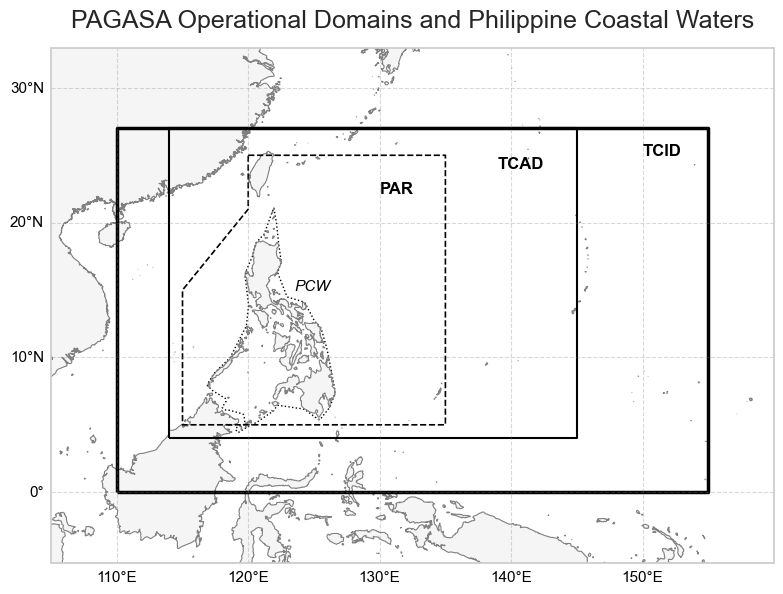

In [639]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Load domain boundaries (already in EPSG:4326)
gdf_tcid = gpd.read_file("PAGASA_TCID.gpkg").to_crs(4326)
gdf_tcad = gpd.read_file("PAGASA_TCAD.gpkg").to_crs(4326)
gdf_par = gpd.read_file("PAGASA_PAR.gpkg").to_crs(4326)

# Use your existing phil_waters variable
# Assume phil_waters is already loaded and in EPSG:4326

# Create plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add ocean and land
ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.coastlines(resolution='10m', color='gray', linewidth=0.8)

# Plot boundaries with consistent black outlines
gdf_tcid.boundary.plot(ax=ax, edgecolor='black', linewidth=2.5, linestyle='-')
gdf_tcad.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, linestyle='-')
gdf_par.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2, linestyle='--')

# Overlay Philippine Coastal Waters (PCW)
phil_waters.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.0, linestyle=':')

# Add domain labels
ax.text(150, 25, "TCID", fontsize=12, fontweight='bold', color='black')
ax.text(139, 24, "TCAD", fontsize=12, fontweight='bold', color='black')
ax.text(130, 22.2, "PAR", fontsize=12, fontweight='bold', color='black')
ax.text(123.5, 15, "PCW", fontsize=11, style='italic', color='black')

# Set map extent
ax.set_extent([105, 160, -5, 30])

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.8, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(100, 175, 10))
gl.ylocator = mticker.FixedLocator(np.arange(0, 45, 10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': 'black'}
gl.ylabel_style = {'size': 11, 'color': 'black'}

# Title and save
ax.set_title("PAGASA Operational Domains and Philippine Coastal Waters", fontsize=18, pad=15)
plt.tight_layout()
plt.savefig("tc_domains_reference_map.png", dpi=300, bbox_inches='tight')
plt.show()
